In [3]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from datetime import datetime


plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv('./Train.csv')
df_test = pd.read_csv('./Test.csv')

In [16]:
df.head()

ID       DATOP     FLTID DEPSTN ARRSTN                  STD  \
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00   
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   STA STATUS         AC  target  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0  
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0

In [4]:
df['DATOP'].unique()

array(['2016-01-03', '2016-01-13', '2016-01-16', ..., '2018-12-28',
       '2018-12-29', '2018-12-30'], dtype=object)

**Dates of flights from 2016-01-03 till 2018-12-30**

DATOP - Date of flight

FLTID - Flight number

DEPSTN - Departure point

ARRSTN - Arrival point

STD - Scheduled Time departure

STA - Scheduled Time arrival

STATUS - Flight status

AC - Aircraft Code

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
ID        107833 non-null object
DATOP     107833 non-null datetime64[ns]
FLTID     107833 non-null object
DEPSTN    107833 non-null object
ARRSTN    107833 non-null object
STD       107833 non-null datetime64[ns]
STA       107833 non-null datetime64[ns]
STATUS    107833 non-null object
AC        107833 non-null object
target    107833 non-null float64
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 8.2+ MB


In [8]:
df.shape

(107833, 10)

In [10]:
df['target'].mean()

48.73301308504818

In [17]:
# # df[['DATOP', 'STD', 'STA']]
df['STD'] =  pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')
df['STA'] =  pd.to_datetime(df['STA'], format='%Y-%m-%d %H.%M.%S')
df['DATOP'] =  pd.to_datetime(df['DATOP'], format='%Y-%m-%d')

df_test['STD'] =  pd.to_datetime(df_test['STD'], format='%Y-%m-%d %H:%M:%S')
df_test['STA'] =  pd.to_datetime(df_test['STA'], format='%Y-%m-%d %H.%M.%S')
df_test['DATOP'] =  pd.to_datetime(df_test['DATOP'], format='%Y-%m-%d')

In [18]:
# there is a space after the flight id
df['FLTID'] = df['FLTID'].astype(str).str[:-1]
df_test['FLTID'] = df_test['FLTID'].astype(str).str[:-1]

In [143]:
df['FLTID'][0]

'TU 0712'

In [44]:
df['STATUS'].unique()

array(['ATA', 'DEP', 'RTR', 'SCH', 'DEL'], dtype=object)

In [45]:
df.isnull().sum(axis=0).reset_index()

index  0
0      ID  0
1   DATOP  0
2   FLTID  0
3  DEPSTN  0
4  ARRSTN  0
5     STD  0
6     STA  0
7  STATUS  0
8      AC  0
9  target  0

We don't have missing values

In [46]:
df['AC'].unique()

array(['TU 32AIMN', 'TU 31BIMO', 'TU 736IOK', 'TU 320IMU', 'TU 736IOP',
       'TU 32AIMH', 'TU 32AIMI', 'TU 32AIMC', 'TU 31AIMK', 'TU 32AIMF',
       'TU 32AIMP', 'TU 320IMR', 'TU 332IFN', 'TU 31AIMJ', 'TU 320IMT',
       'TU 736IOL', 'TU 31BIMQ', 'TU 736IOR', 'TU 320IMV', 'TU 320IMS',
       'TU 332IFM', 'TU 320IMW', 'TU 32AIML', 'TU 32AIMD', 'TU 32AIMM',
       'TU CR9ISA', 'TU 32AIMG', 'TU 736ION', 'TU 736IOM', 'TU 736IOQ',
       '5M 343SUN', 'UG AT7LBD', '5K 343TQY', 'UG AT7LBE', 'UG AT7AT7',
       'BJ 320INP', 'BJ 320INH', 'BJ 320INQ', 'BJ 320INA', 'UG CR9XXX',
       'UG CR9CR9', 'TU 32A32A', 'BJ 320INB', 'GJ 734CGC', 'QS 738TSC',
       'PS 738PSD', 'D4 319CQG', 'BJ 320INR', 'BJ 320INC', 'UJ 320TCF',
       '5K 345TFX', 'D4 320CQP', '5M 343JAI', 'GW 320MQH', 'UG CR9ISA',
       '6P M87TRJ', 'TU CR9CR9', 'TU CR9XXX', 'GJ 733EWE', 'GJ 734PGC',
       'GJ 733GGC', 'GJ 734MGC', 'GJ 733LGC', '5M 343FOX', 'BJ 320INO',
       'OL 321ABY', 'X9 320VEB', 'TU 320320'], dtype=object)

In [151]:
df['target'].mean()

48.73301308504818

**The mean delay time is 48.73 minutes let's take a closer look on how the delay times are dispersed**


<h2> Comparing delay times per AC </h2>

In [20]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['target'].groupby(df['AC']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

min     max   count        mean
AC                                        
TU 320320  0.0     0.0     1.0    0.000000
TU CR9XXX  0.0     0.0     2.0    0.000000
TU 32A32A  0.0     0.0     2.0    0.000000
OL 321ABY  0.0   302.0     5.0  205.400000
TU CR9CR9  0.0     0.0     6.0    0.000000
...        ...     ...     ...         ...
TU 320IMV  0.0  2042.0  4589.0   56.915232
TU 320IMR  0.0  1890.0  4601.0   58.260378
TU 320IMT  0.0  2835.0  4634.0   58.406129
TU 320IMW  0.0  2745.0  4685.0   61.432444
TU 320IMU  0.0  3317.0  4724.0   58.867697

[68 rows x 4 columns]

In [21]:
global_stats.sort_values('max')

min     max   count       mean
AC                                       
TU 320320  0.0     0.0     1.0   0.000000
UG CR9CR9  0.0     0.0    30.0   0.000000
UG AT7AT7  0.0     0.0  1441.0   0.000000
TU CR9CR9  0.0     0.0     6.0   0.000000
UG CR9XXX  0.0     0.0    80.0   0.000000
...        ...     ...     ...        ...
TU 320IMS  0.0  2942.0  4214.0  57.329616
TU 736IOQ  0.0  2980.0  3072.0  39.202474
TU 32AIML  0.0  3245.0  4122.0  61.064774
TU 320IMU  0.0  3317.0  4724.0  58.867697
TU 32AIMM  0.0  3451.0  2632.0  63.453267

[68 rows x 4 columns]

**The mean delay times are between 0 minutes and 205.4 minutes (the max delay of all flights is 3451 minutes)**

(-1.10061729084274, 1.1000293955290301, -1.1007992111719394, 1.100059960254189)

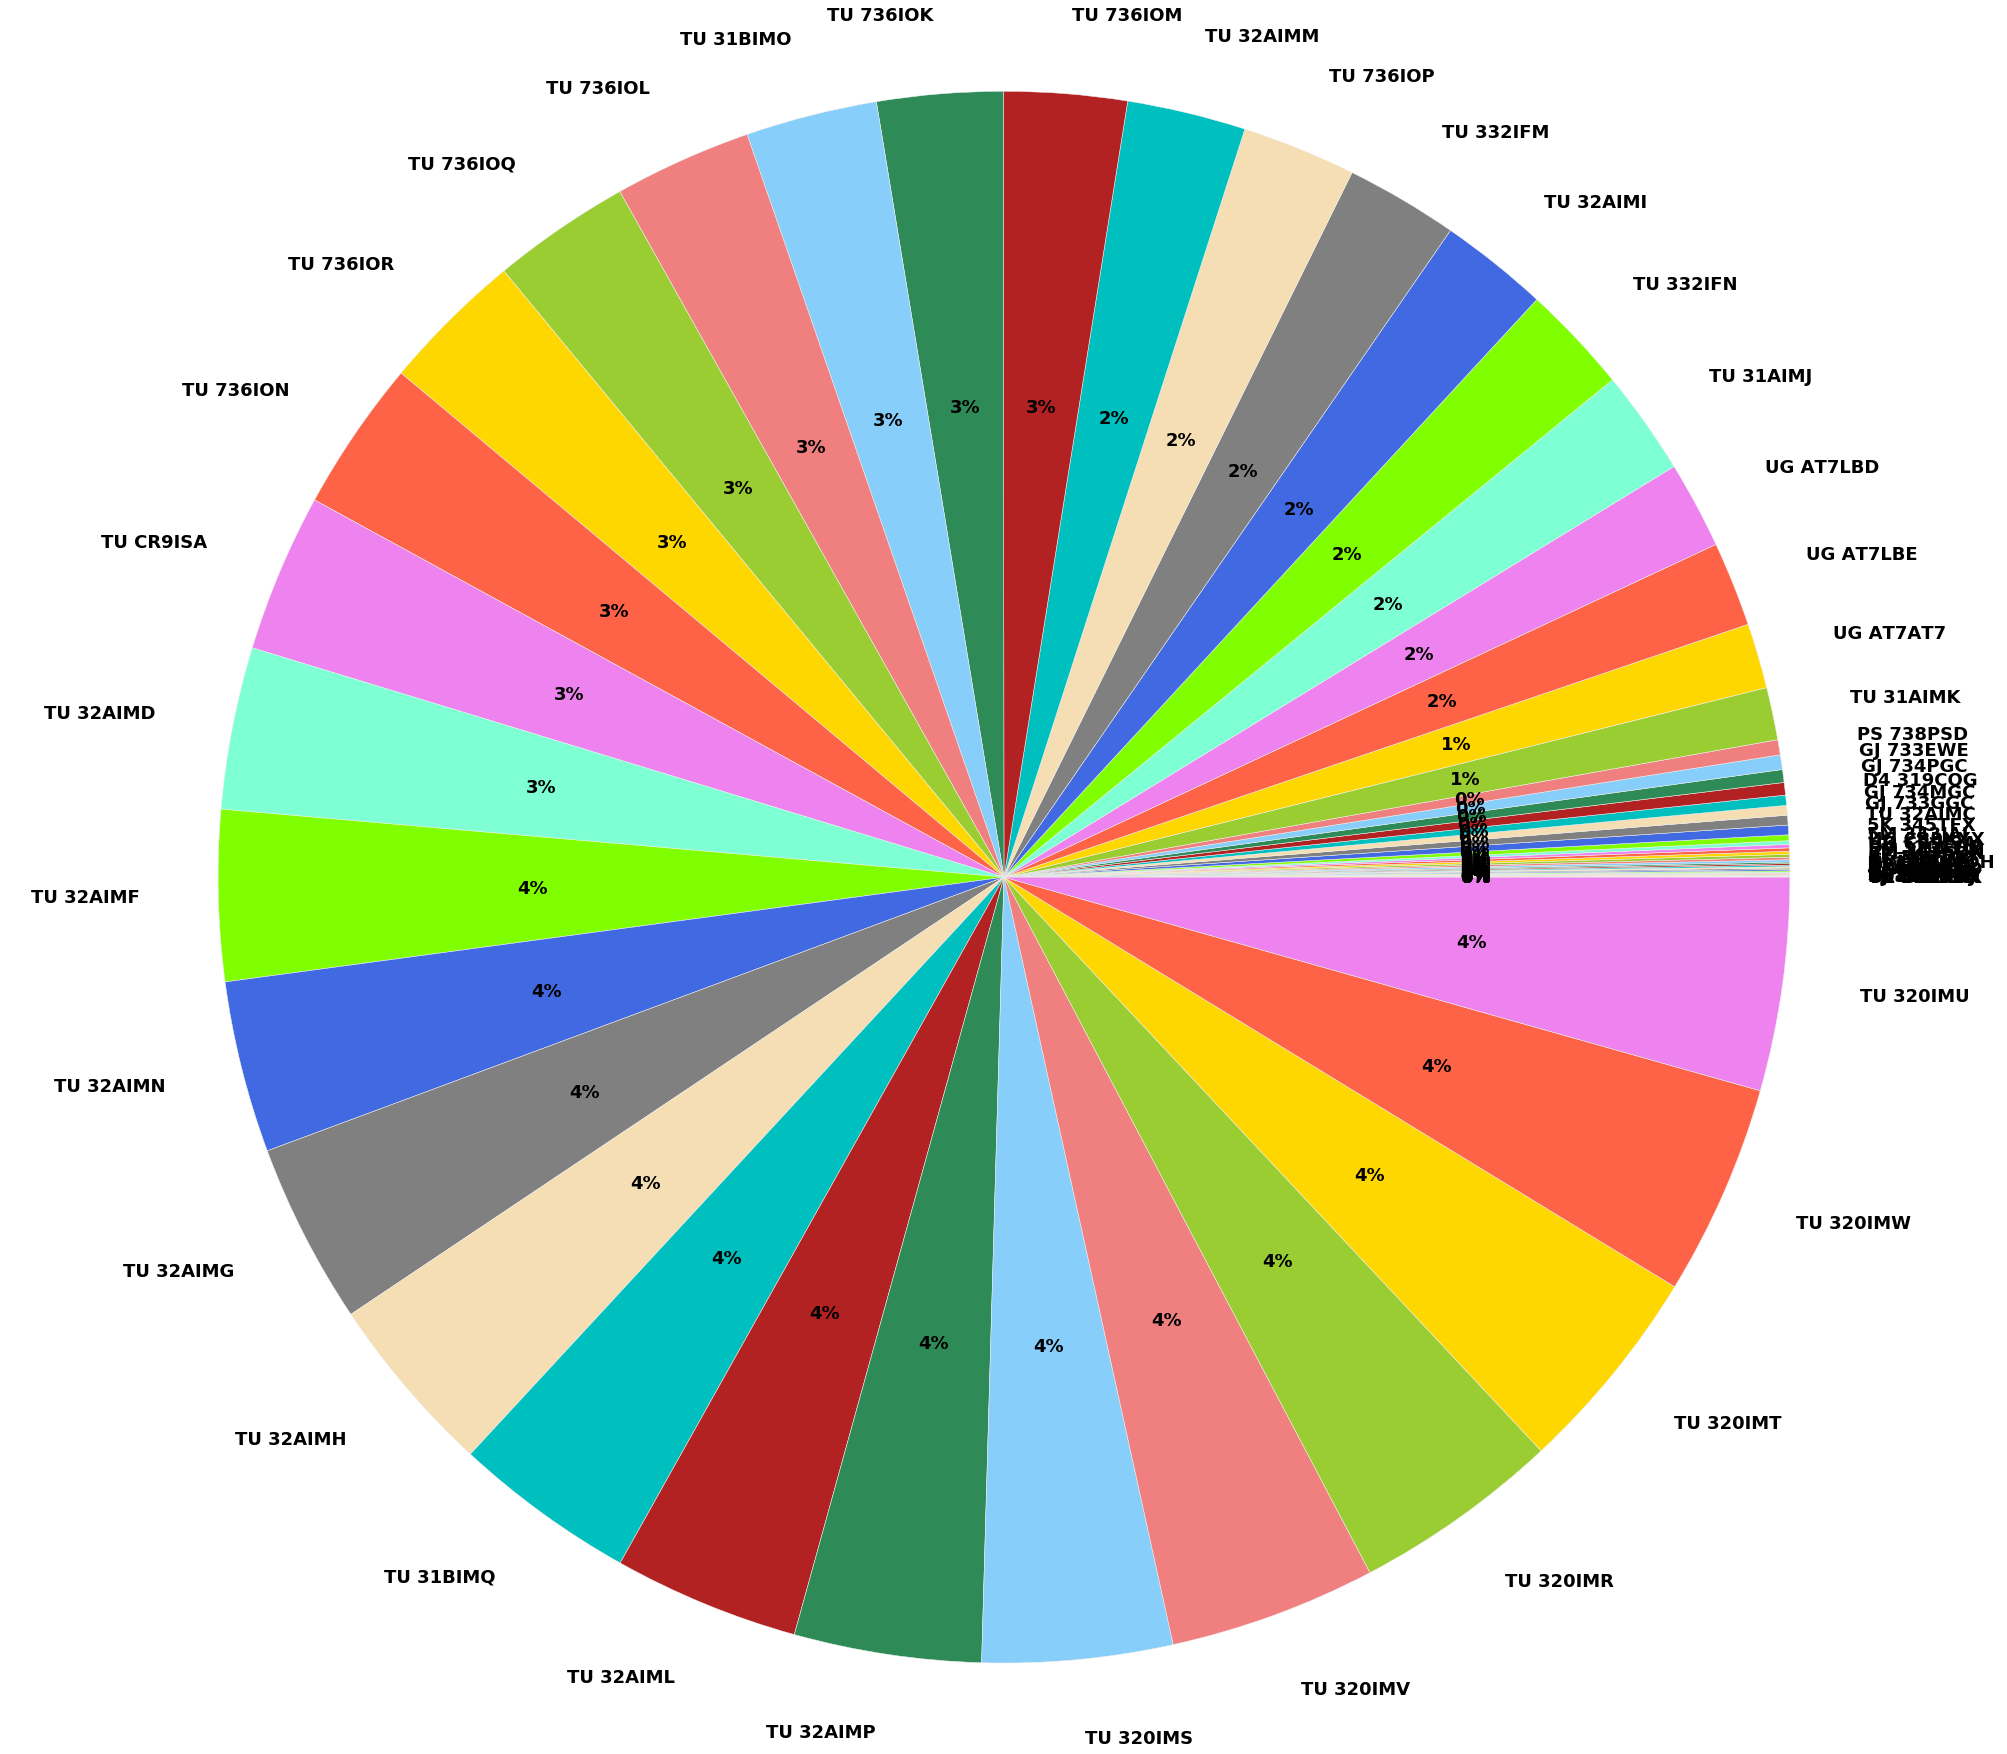

In [149]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 18}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
df2 = df.loc[:, ['AC', 'target']]
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

fig = plt.figure(1, figsize=(70,70))
# gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
# Pie chart nº1: nb of flights
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 1.0 else 0.0 for i in range(len(sizes))]
patches, texts, autotexts = ax1.pie(sizes, explode=explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
ax1.axis('equal')
# ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':10},
#               color = 'w',fontsize=18)

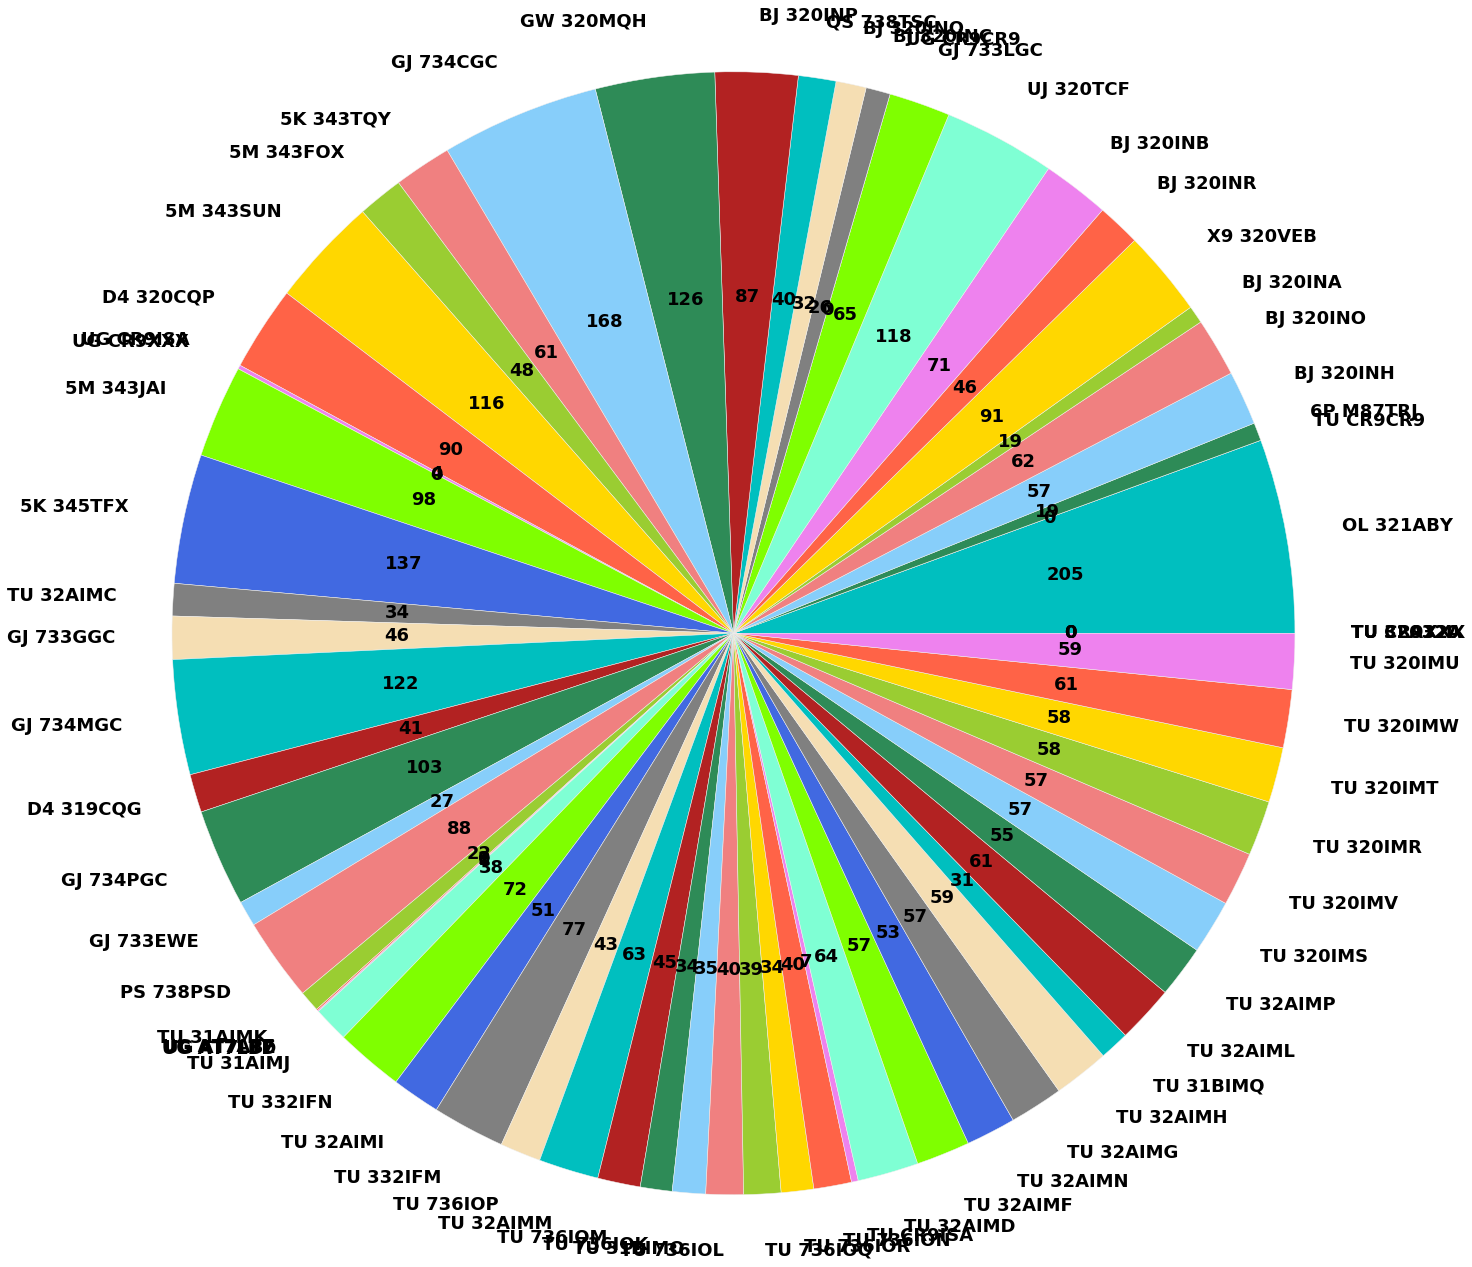

In [142]:
# ax2=fig.add_subplot(gs[0,1]) 
# Pie chart nº2: mean delay at departure
fig = plt.figure(1, figsize=(50,50))
ax2=fig.add_subplot(gs[0,0])
labels = [s for s in  global_stats.index]
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
patches, texts, autotexts = ax2.pie(sizes, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
ax2.axis('equal')
# ax2.set_title('Mean delay', bbox={'facecolor':'midnightblue', 'pad':5},
#               color='w', fontsize=24)
plt.show()

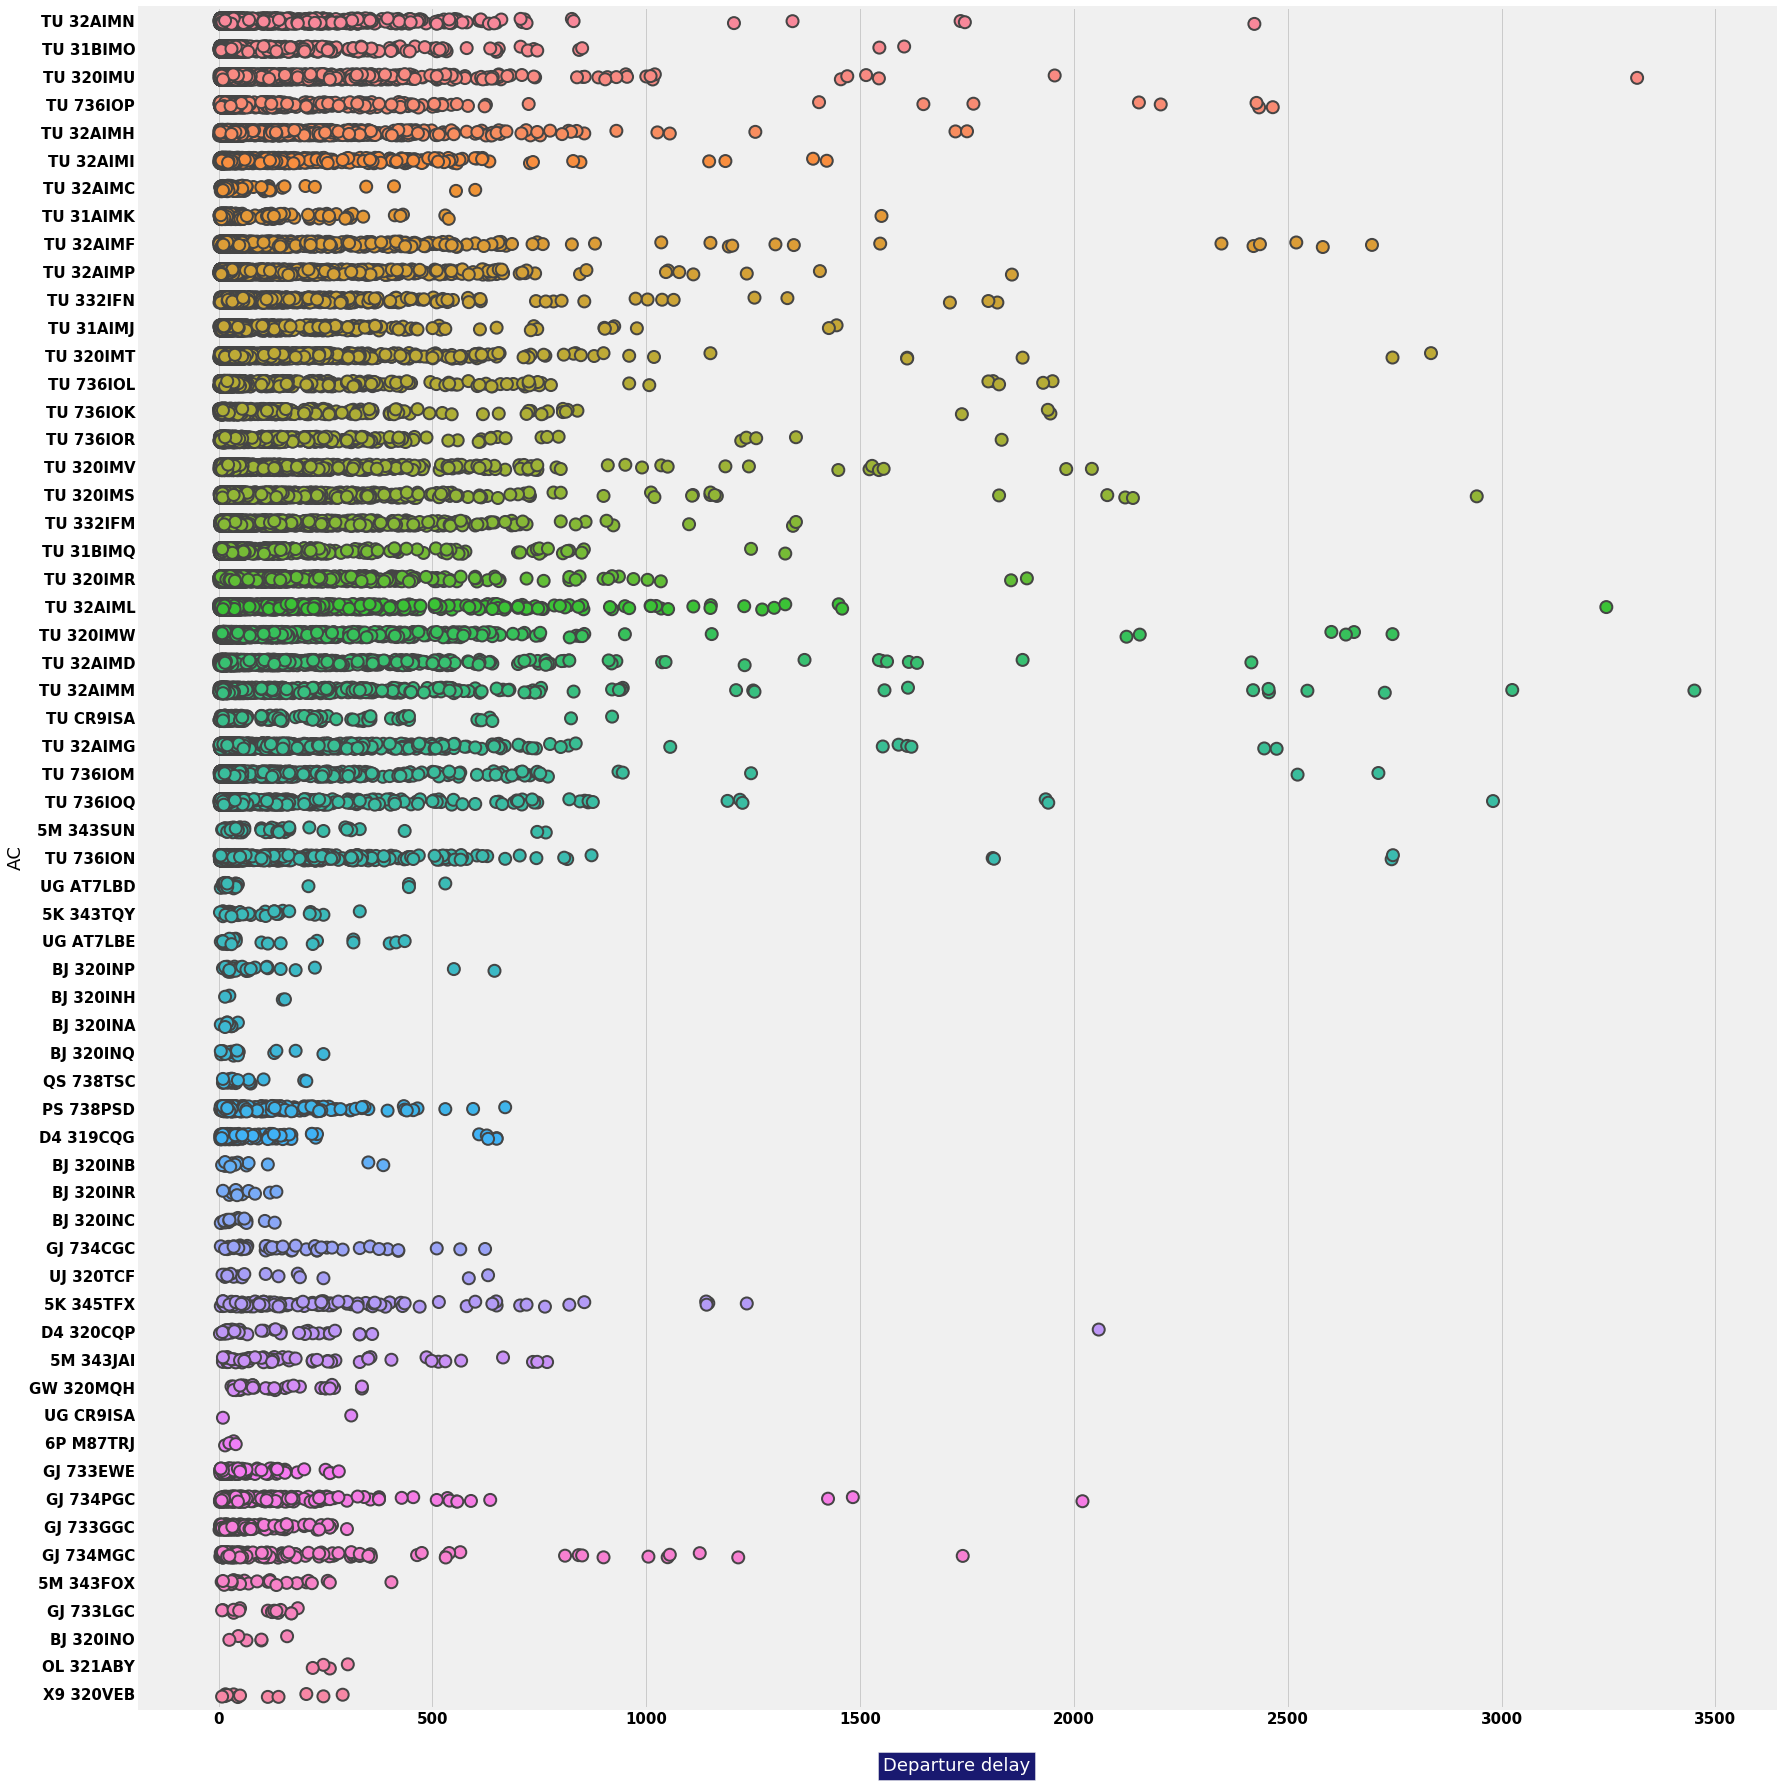

In [114]:
fig = plt.figure(1, figsize=(25,25))
df2 = df.loc[:, ['AC', 'target']]
df2 = df2.drop(df2[df2.target == 0].index)
ax = sns.stripplot(x="target", y="AC", data=df2, size = 12, linewidth = 2,  jitter=True)
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=30)
ax3.yaxis.label.set_visible(False)
plt.tight_layout(w_pad=3) 

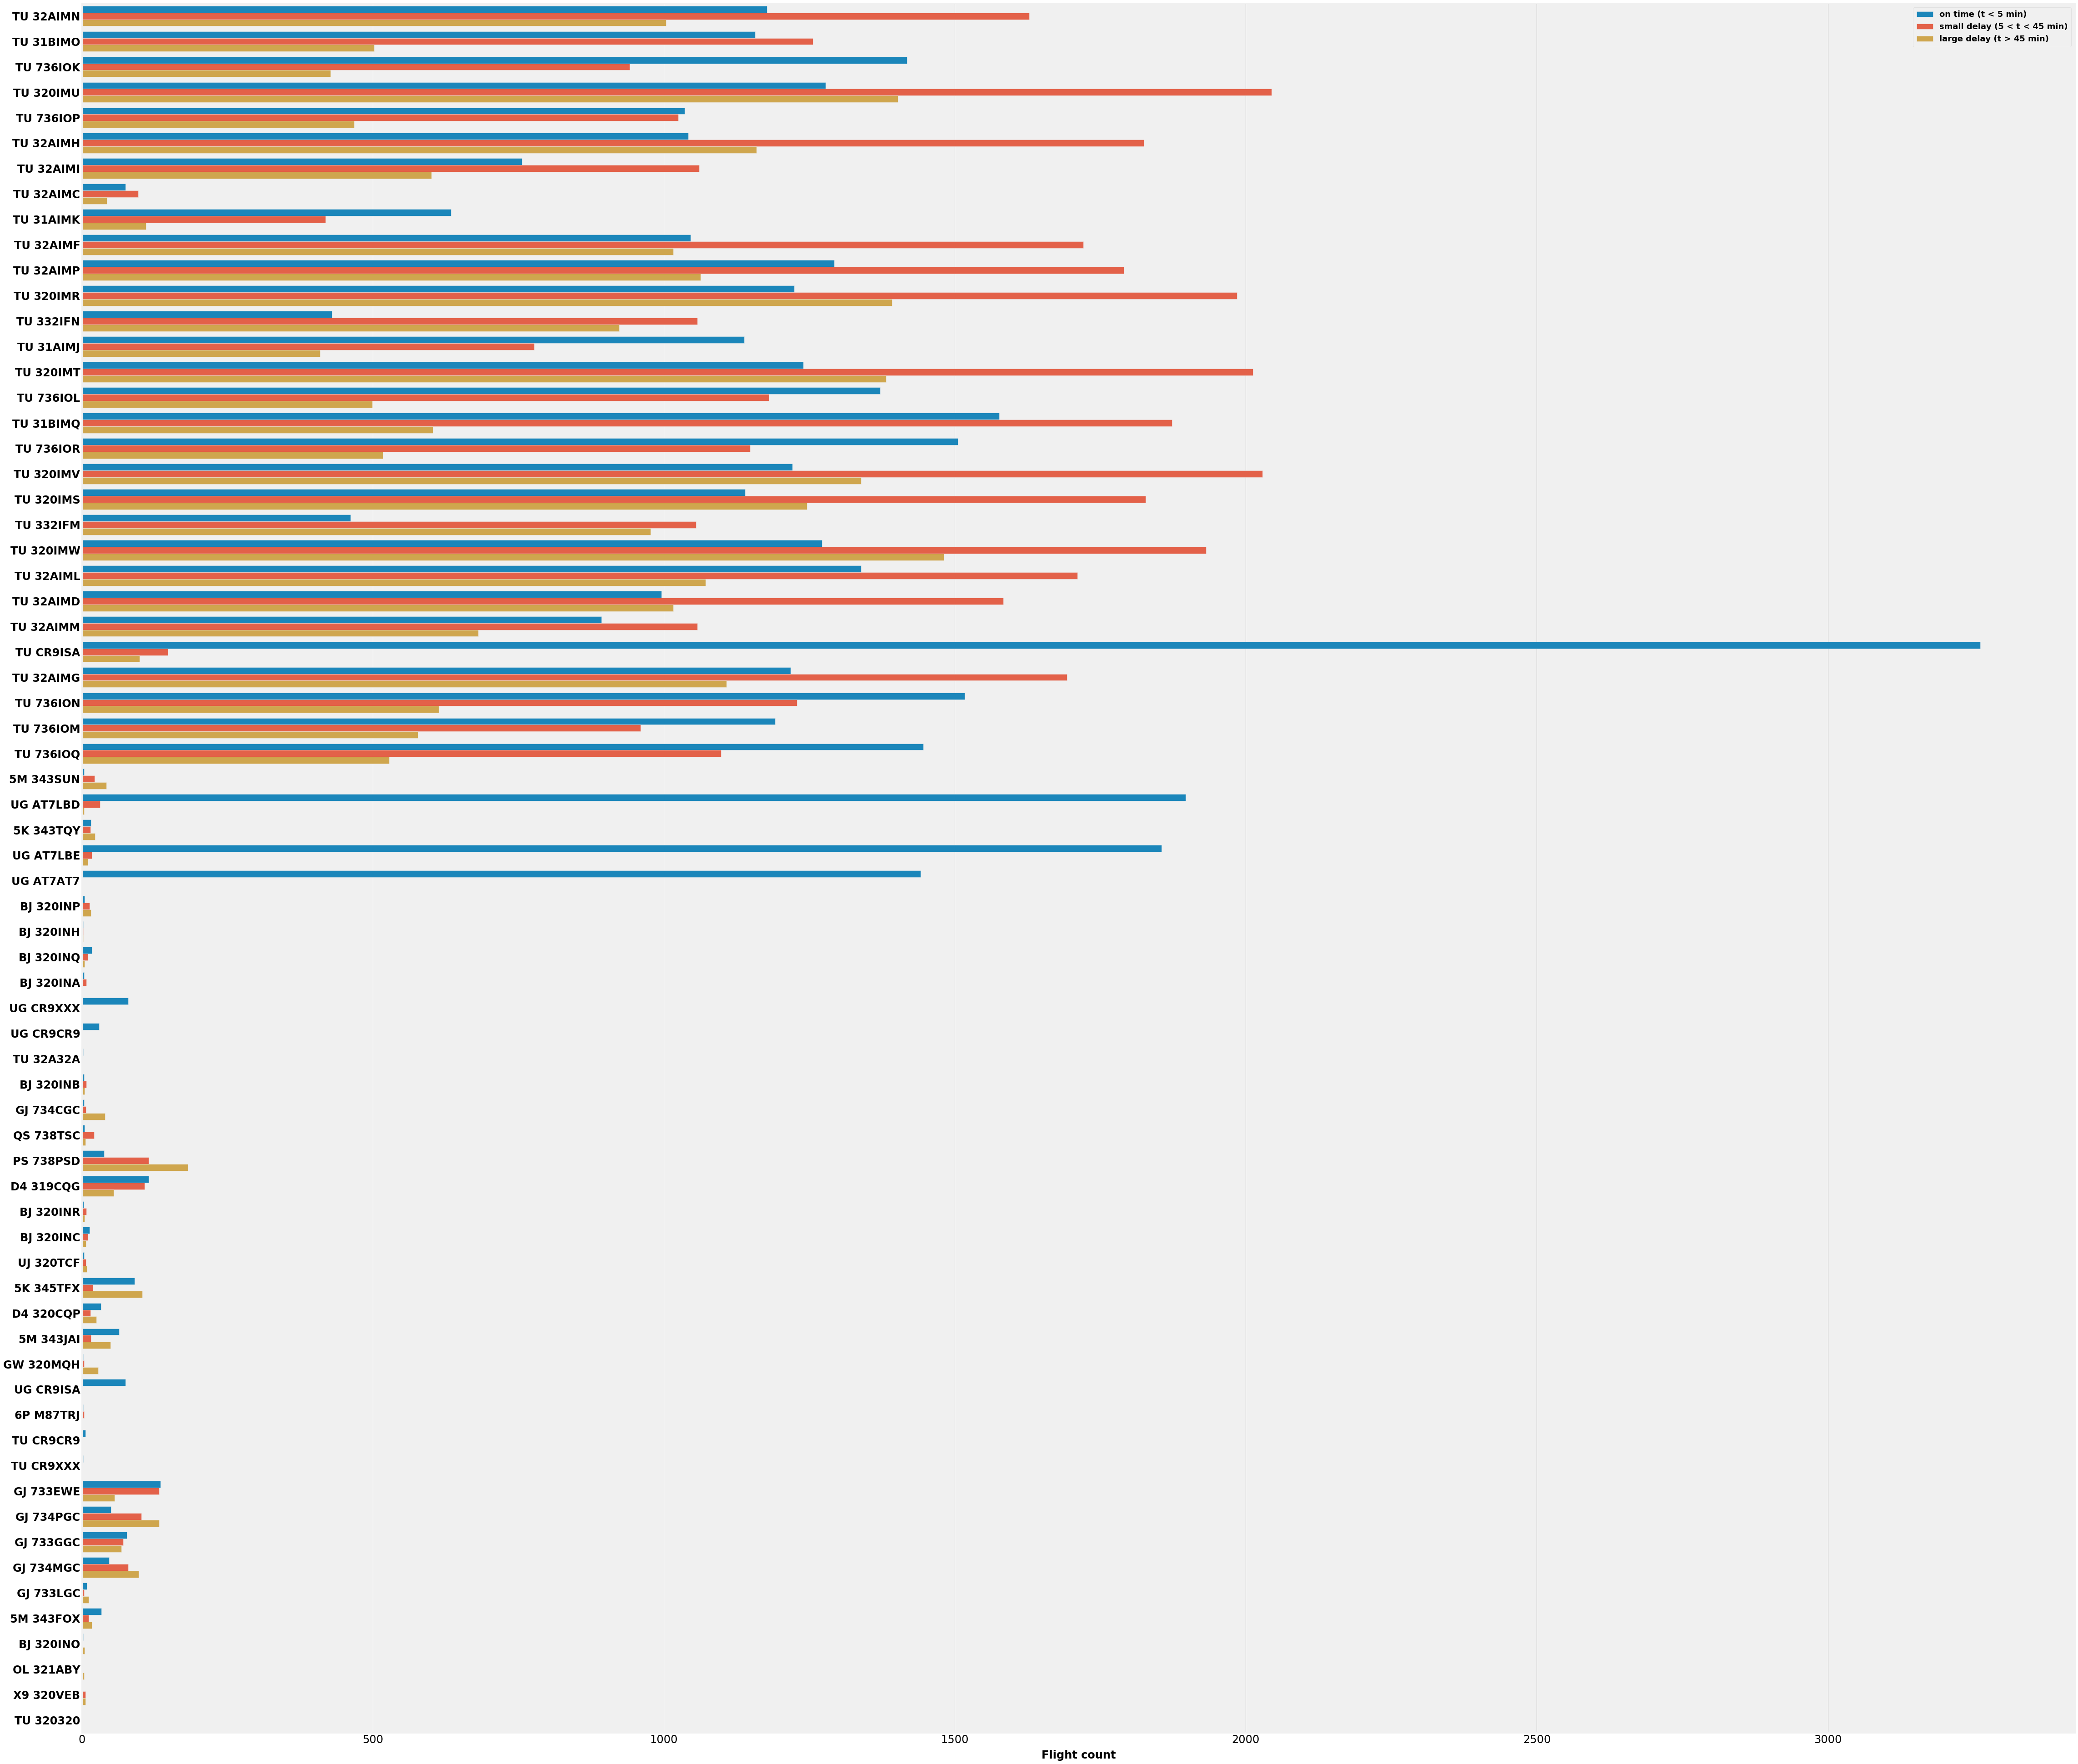

In [159]:
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['target'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(70,70))
ax = sns.countplot(y="AC", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = df['AC'].unique().tolist()
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=24, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=24, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=24, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

<h2>Relationship between the origin airport and delays</h2>

In [7]:
print("Nb of airports: {}".format(len(df['DEPSTN'].unique())))

Nb of airports: 132


In [5]:
list_of_airpots = df['DEPSTN'].unique().tolist()
list_of_ac = df['AC'].unique().tolist()
origin_nb = dict()
for carrier in list_of_ac:
    liste_origin_airport = df[df['AC'] == carrier]['DEPSTN'].unique().tolist()
    origin_nb[carrier] = len(liste_origin_airport)

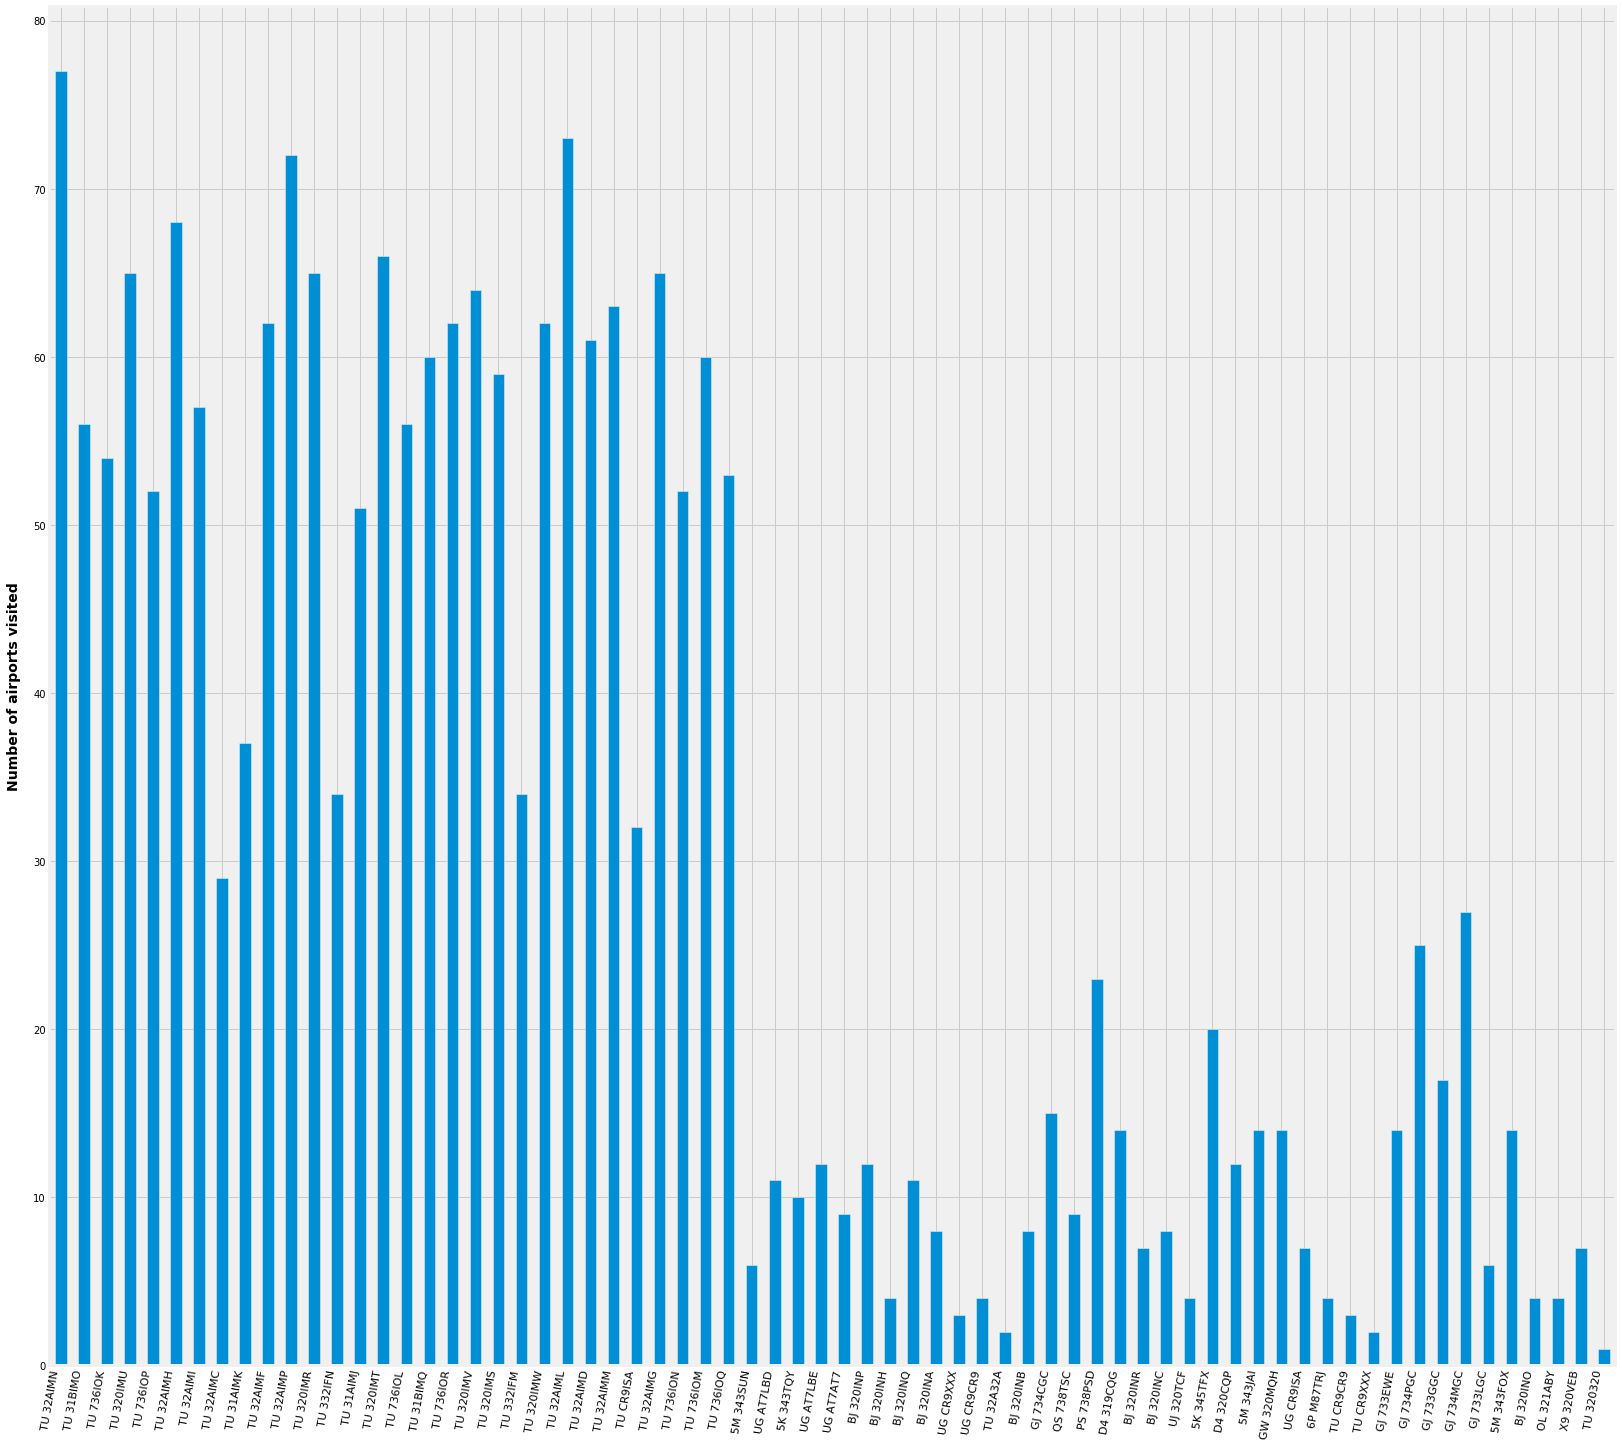

In [8]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (25,25))
labels = [x for x in list_of_ac]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

**number of flights per year**

In [170]:
# df['month'] = pd.DatetimeIndex(df['DATOP']).month
df['year'] = pd.DatetimeIndex(df['DATOP']).year
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  year  
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0  2016  
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0  2016  
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0  2016  
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0  2016  
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0  2016

In [171]:
flights_dict = dict()
ac_group = df.groupby('AC')
for x in list_of_ac:
    df_ac = ac_group.get_group(x)
    flights_dict[x] = df[df['AC'] == x]['year'].value_counts().to_dict()

In [12]:
flights_dict

{'TU 32AIMN': {2018: 1569, 2017: 1264, 2016: 976},
 'TU 31BIMO': {2016: 1265, 2018: 1125, 2017: 525},
 'TU 736IOK': {2018: 1363, 2016: 1316, 2017: 107},
 'TU 320IMU': {2018: 1644, 2017: 1602, 2016: 1478},
 'TU 736IOP': {2017: 1376, 2016: 1065, 2018: 88},
 'TU 32AIMH': {2017: 1575, 2018: 1469, 2016: 982},
 'TU 32AIMI': {2016: 1290, 2018: 999, 2017: 129},
 'TU 32AIMC': {2016: 213, 2018: 1, 2017: 1},
 'TU 31AIMK': {2016: 1081, 2017: 81, 2018: 1},
 'TU 32AIMF': {2018: 1441, 2016: 1322, 2017: 1020},
 'TU 32AIMP': {2017: 1580, 2018: 1412, 2016: 1154},
 'TU 320IMR': {2017: 1643, 2018: 1620, 2016: 1338},
 'TU 332IFN': {2018: 903, 2017: 811, 2016: 697},
 'TU 31AIMJ': {2017: 1212, 2016: 1110, 2018: 2},
 'TU 320IMT': {2017: 1638, 2018: 1554, 2016: 1442},
 'TU 736IOL': {2018: 1198, 2017: 1006, 2016: 847},
 'TU 31BIMQ': {2018: 1490, 2016: 1296, 2017: 1266},
 'TU 736IOR': {2018: 1160, 2016: 1104, 2017: 906},
 'TU 320IMV': {2018: 1610, 2017: 1563, 2016: 1416},
 'TU 320IMS': {2016: 1461, 2017: 1410, 2

In [172]:
# flights_dict
nbr_flights = pd.DataFrame.from_dict(flights_dict, orient='index')
nbr_flights.fillna(0, inplace=True)
# nbr_flights

In [173]:
nbr_flights.columns = ['flights_in_2018', 'flights_in_2017', 'flights_in_2016']

In [174]:
nbr_flights['flights_in_2016'] = nbr_flights['flights_in_2016'].astype(np.int64)
nbr_flights['flights_in_2017'] = nbr_flights['flights_in_2017'].astype(np.int64)
nbr_flights['flights_in_2018'] = nbr_flights['flights_in_2018'].astype(np.int64)
nbr_flights['total_flights'] = nbr_flights['flights_in_2016'] + nbr_flights['flights_in_2017'] + nbr_flights['flights_in_2018']
# nbr_flights

flights_in_2018  flights_in_2017  flights_in_2016  total_flights
5K 343TQY                0                0               54             54
5K 345TFX               73              141                0            214
5M 343FOX               63                0                0             63
5M 343JAI                0              129                0            129
5M 343SUN                0                0               68             68
6P M87TRJ                0                6                0              6
BJ 320INA                0                7                5             12
BJ 320INB                6               11                0             17
BJ 320INC               12               18                0             30
BJ 320INH                0                1                5              6
BJ 320INO                8                0                0              8
BJ 320INP                4                8               22             34
BJ 320INQ                0               14               18             32
BJ 320INR                4               12                0             16
D4 319CQG                0              278                0            278
D4 320CQP                0               73                0             73
GJ 733EWE              324                0                0            324
GJ 733GGC              216                0                0            216
GJ 733LGC               25                0                0             25
GJ 734CGC               37               14                0             51
GJ 734MGC              225                0                0            225
GJ 734PGC              285                0                0            285
GW 320MQH                0               34                0             34
OL 321ABY                5                0                0              5
PS 738PSD                0              335                0            335
QS 738TSC                0               32                0             32
TU 31AIMJ                2             1212             1110           2324
TU 31AIMK                1               81             1081           1163
TU 31BIMO             1125              525             1265           2915
TU 31BIMQ             1490             1266             1296           4052
...                    ...              ...              ...            ...
TU 32AIMC                1                1              213            215
TU 32AIMD             1450             1273              872           3595
TU 32AIMF             1441             1020             1322           3783
TU 32AIMG             1432             1556             1031           4019
TU 32AIMH             1469             1575              982           4026
TU 32AIMI              999              129             1290           2418
TU 32AIML             1513             1323             1286           4122
TU 32AIMM              399             1348              885           2632
TU 32AIMN             1569             1264              976           3809
TU 32AIMP             1412             1580             1154           4146
TU 332IFM              958              870              666           2494
TU 332IFN              903              811              697           2411
TU 736IOK             1363              107             1316           2786
TU 736IOL             1198             1006              847           3051
TU 736IOM             1226             1152              350           2728
TU 736ION             1176             1261              922           3359
TU 736IOP               88             1376             1065           2529
TU 736IOQ             1391             1283              398           3072
TU 736IOR             1160              906             1104           3170
TU CR9CR9                0                6                0              6
TU CR9ISA             1529             1219              76

In [47]:
nbr_flights['total_flights'].unique().min()

1

In [48]:
nbr_flights['total_flights'].unique().max()

4724

In [49]:
nbr_flights['flights_in_2018'].unique()

array([   0,   73,   63,    6,   12,    8,    4,  324,  216,   25,   37,
        225,  285,    5,    2,    1, 1125, 1490, 1620, 1343, 1554, 1644,
       1610, 1450, 1441, 1432, 1469,  999, 1513,  399, 1569, 1412,  958,
        903, 1363, 1198, 1226, 1176,   88, 1391, 1160, 1529,  346,  466,
        314,   13])

In [175]:
# add a variable describing the frequency of that AC's flights 3 levels (100 <, 100< < 200, >200) but per year
df['ac_frequency'] = 0
def define_frequency(nbr):
        if nbr<100:
            return 0
        
        else:
            if (nbr>100 and nbr<200): 
                return 1
            else:
                return 2

In [176]:
for i in range(df.shape[0]):
    ac = df.loc[i, 'AC']
    year = df.loc[i, 'year']
    if year == 2016:
        freq_2016 = define_frequency(nbr_flights.loc[ac, 'flights_in_2016'])
        if freq_2016 !=0:
            df.at[i, 'ac_frequency'] = freq_2016
    else:
        if year == 2017:
            freq_2017 = define_frequency(nbr_flights.loc[ac, 'flights_in_2017'])
            if freq_2017 !=0:
                df.at[i, 'ac_frequency'] = freq_2017
        else:
            freq_2018 = define_frequency(nbr_flights.loc[ac, 'flights_in_2018'])
            if freq_2018 !=0:
                df.at[i, 'ac_frequency'] = freq_2018

In [177]:
df.to_csv('/home/souhagaa/Bureau/hackathon/tunisair/Train_interm.csv', index=False)

In [178]:
airport_mean_delays = pd.DataFrame(pd.Series(df['DEPSTN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in list_of_ac:
    df1 = df[df['AC'] == carrier]
    test = df1['target'].groupby(df['DEPSTN']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

In [23]:
airport_mean_delays

TU 32AIMN   TU 31BIMO   TU 736IOK   TU 320IMU   TU 736IOP   TU 32AIMH  \
0                                                                             
CMN   85.260870   50.381579    9.000000   38.070707   44.666667   71.457627   
MXP   72.928571   26.992248   63.384615   62.860465   57.235294   50.710526   
TUN   49.942475   28.700662   30.389868   49.561247   43.560468   51.437832   
DJE   30.598870  226.375000   27.783333   90.250000   32.969359   45.094340   
TLS   78.642857   51.259259   37.857143  100.208333   68.397590   60.269231   
IST   88.414894   32.631579   28.000000   91.392405    6.000000  127.389474   
ORY   51.660317   33.962963   57.276471   47.778302   36.488636   52.159806   
MIR   46.836134   89.000000   27.188119   86.378378   18.096447   67.787037   
BRU   37.091954   37.473684   22.148148   47.342857   69.000000   38.696429   
ABJ   56.600000   57.882353         NaN   91.050000         NaN  145.000000   
VCE   81.909091   22.750000   10.142857   55.227273   42.500000   71.111111   
AMS   39.200000   70.400000   53.833333         NaN   66.352941   74.500000   
FRA   77.437500   31.269231   34.125000   73.142857   32.360000   49.066667   
BCN   31.406250   26.250000         NaN   62.326531   66.500000   35.864407   
JED  185.625000   80.600000         NaN   83.486957         NaN         NaN   
ALG   80.380000   43.500000   14.666667   70.648855         NaN   69.617284   
LIS   16.500000   28.588235   25.181818   53.600000   77.181818   83.875000   
SXB   58.956522   76.250000   40.568182  162.333333   69.411765   73.700000   
LYS   62.028986   64.813953   46.714286   75.222222   58.376623  104.209677   
OUA  235.000000   25.500000         NaN   75.294118  111.000000   55.000000   
LGW   50.894737   44.441176         NaN   60.611111         NaN   82.000000   
BEY   62.500000   20.764706         NaN   22.978261         NaN   76.428571   
NCE   35.564103   24.206897   34.650602   43.346535   44.360000   75.909091   
OPO         NaN         NaN   10.777778         NaN   36.500000         NaN   
MRS   52.720280   90.625000   27.571429   59.900901   25.945946   68.852113   
DUS   53.000000   26.500000   42.421875   47.400000   47.960000   52.631579   
SFA  181.000000    7.500000   14.914894   46.514286   20.000000    0.000000   
FCO   48.230769   17.850220   46.400000   56.080000   16.666667   32.927273   
CDG  103.214286   45.000000   85.596491   36.500000   65.387755  116.625000   
NKC  145.000000   78.884615         NaN  116.205882         NaN  111.444444   
..          ...         ...         ...         ...         ...         ...   
SKG         NaN         NaN         NaN         NaN         NaN         NaN   
ADB         NaN         NaN         NaN         NaN         NaN         NaN   
DSS  130.000000   70.250000         NaN   58.086957         NaN   35.000000   
DOH         NaN         NaN         NaN         NaN         NaN         NaN   
COO    5.000000   94.222222         NaN   37.764706         NaN         NaN   
LUX    0.000000         NaN         NaN         NaN         NaN         NaN   
FIH         NaN         NaN         NaN         NaN         NaN         NaN   
BYJ         NaN         NaN         NaN         NaN         NaN         NaN   
KEF         NaN         NaN         NaN         NaN         NaN         NaN   
EBM         NaN         NaN         NaN         NaN         NaN         NaN   
BDS         NaN         NaN         NaN  202.000000         NaN         NaN   
AAL         NaN         NaN         NaN         NaN         NaN         NaN   
VKO   33.444444         NaN         NaN   65.000000         NaN  127.000000   
AAE         NaN         NaN         NaN         NaN         NaN  157.000000   
BRI         NaN         NaN         NaN         NaN         NaN         NaN   
VRN  570.000000         NaN   28.333333         NaN         NaN    0.000000   
SKX         NaN         NaN         NaN         NaN         NaN         NaN   
HAJ   74.000000         NaN         NaN         NaN     

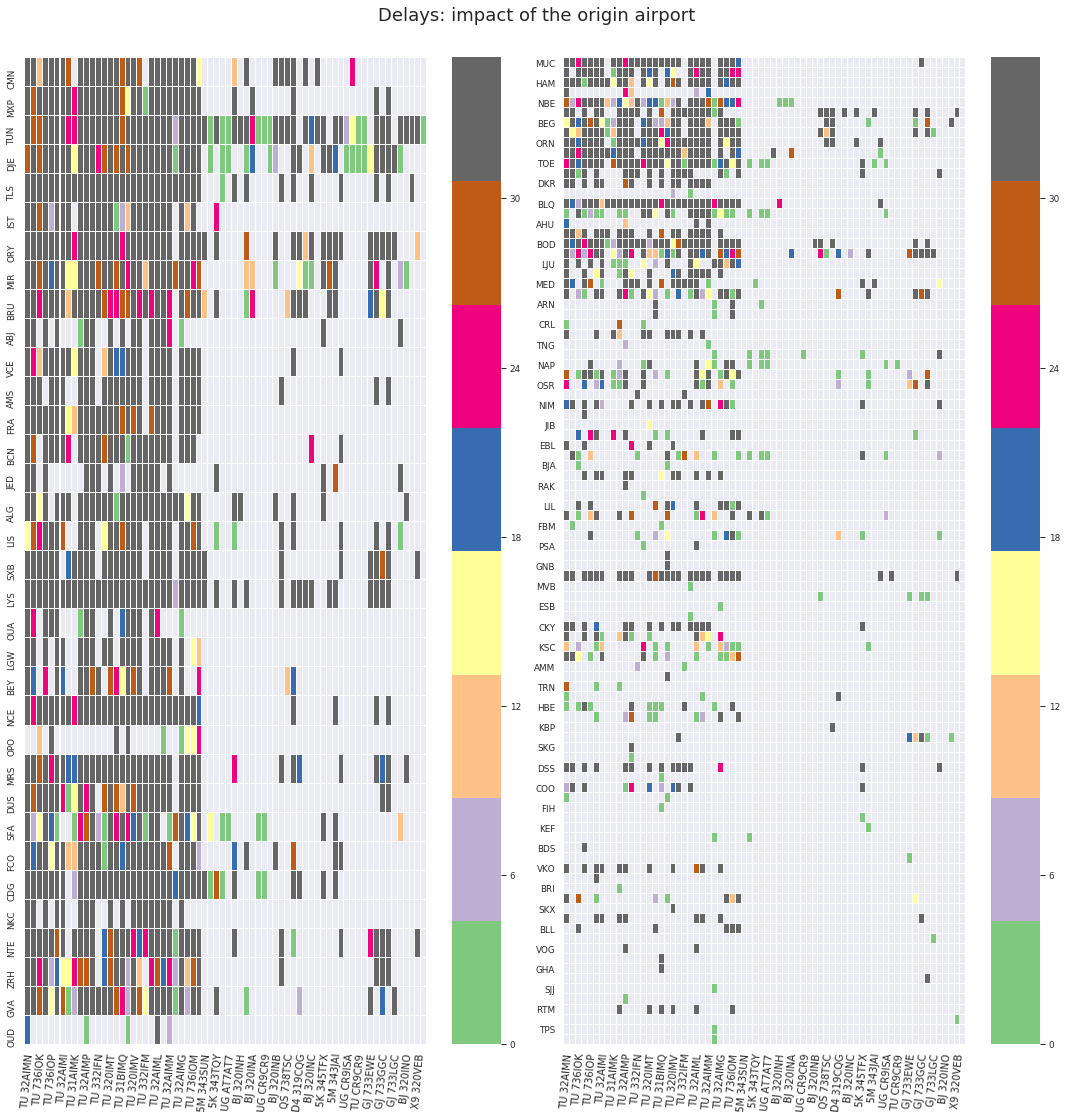

In [35]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(15,15))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:34,:]
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)
subset = airport_mean_delays.iloc[34:,:]
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

**As we can see the departure airport has a great impact on the delay we can see the dominance of large delays in a lot of airports like LYS and SXB in the left panel**

-> There is a high variability in average delays, both between the different airports but also between the different airlines. This is important because it implies that in order to accurately model the delays, it will be necessary to adopt a model that is specific to the company and the home airport .

In [13]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0  
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0  
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0  
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0  
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0

<h2> Feature Engineering </h2>

Label encoding

In [2]:
df = pd.read_csv('/home/souhagaa/Bureau/hackathon/tunisair/Train_interm.csv')

In [38]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target trajectory  month  day  \
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0    CMN-TUN      1    3   
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0    MXP-TUN      1   13   
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0    TUN-IST      1   16   
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0    DJE-NTE      1   17   
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0    TUN-ALG      1   17   

   day_of_week  year  week_of_year  week_of_month  season  dep_hour  arr_hour  \
0            6  2016            53              0       0        10        12   
1            2  2016             2              1       0        15        16   
2            5  2016             2              2       0         4         6   
3            6  2016             2              2       0        14        17   
4            6  2016             2              2       0        14        15   

   dep_minute  arr_minute  flight_duration_sec  flight_duration_hours  \
0          30          55                 8700                      2   
1           5          55                 6600                      1   
2          10          45                 9300                      2   
3          10           0                10200                      3   
4          30          50                 4800                      1   

   flight_duration_minutes  dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour  \
0                      145               0               1    0.500000   
1                      110               1               1   -0.707107   
2                      155               0               0    0.866025   
3                      170               1               1   -0.500000   
4                       80               1               1   -0.500000   

   C_dep_hour    S_arr_hour    C_arr_hour  day_of_year  
0   -0.866025  1.224647e-16 -1.000000e+00          3.0  
1   -0.707107 -8.660254e-01 -5.000000e-01         13.0  
2    0.500000  1.000000e+00  6.123234e-17         16.0  
3   -0.866025 -9.659258e-01 -2.588190e-01         17.0  
4   -0.866025 -7.071068e-01 -7.071068e-01         17.0

In [22]:
df['trajectory'] = df['DEPSTN'] + '-' + df['ARRSTN']
df_test['trajectory'] = df_test['DEPSTN'] + '-' + df_test['ARRSTN']

In [23]:
df['trajectory'].nunique()

741

In [24]:
df['month'] = pd.DatetimeIndex(df['DATOP']).month
df['day'] = pd.DatetimeIndex(df['DATOP']).day
df['day_of_week'] = pd.DatetimeIndex(df['DATOP']).dayofweek
df['year'] = pd.DatetimeIndex(df['DATOP']).year
df['week_of_year'] = pd.DatetimeIndex(df['DATOP']).week

In [25]:
df_test['month'] = pd.DatetimeIndex(df_test['DATOP']).month
df_test['day'] = pd.DatetimeIndex(df_test['DATOP']).day
df_test['day_of_week'] = pd.DatetimeIndex(df_test['DATOP']).dayofweek
df_test['year'] = pd.DatetimeIndex(df_test['DATOP']).year
df_test['week_of_year'] = pd.DatetimeIndex(df_test['DATOP']).week

In [26]:
# Adding a week of month variable
data = [df, df_test]
for dataset in data:
    dataset.loc[ dataset['day'] <= 7, 'week_of_month'] = 0
    dataset.loc[(dataset['day'] > 7) & (dataset['day'] <= 14), 'week_of_month'] = 1
    dataset.loc[(dataset['day'] > 14) & (dataset['day'] <= 21), 'week_of_month'] = 2
    dataset.loc[(dataset['day'] > 21) & (dataset['day'] <= 28), 'week_of_month'] = 3
    dataset.loc[(dataset['day'] > 28) & (dataset['day'] <= 31), 'week_of_month'] = 4
    dataset['week_of_month'] = dataset['week_of_month'].astype(int)

In [27]:
# Adding a season column depicting the season the flight has taken place in
data = [df, df_test]
for dataset in data:
    dataset.loc[ (dataset['month'] < 3) | (dataset['month'] == 12), 'season'] = 0
    dataset.loc[(dataset['month'] >= 3) & (dataset['month'] < 6), 'season'] = 1
    dataset.loc[(dataset['month'] >= 6) & (dataset['month'] < 9), 'season'] = 2
    dataset.loc[(dataset['month'] >= 9) & (dataset['month'] < 12), 'season'] = 3
    dataset['season'] = dataset['season'].astype(int)

In [28]:
df['dep_hour'] = pd.DatetimeIndex(df['STD']).hour 
df_test['dep_hour'] = pd.DatetimeIndex(df_test['STD']).hour


df['arr_hour'] = pd.DatetimeIndex(df['STA']).hour 
df_test['arr_hour'] = pd.DatetimeIndex(df_test['STA']).hour

In [29]:
df['dep_minute'] = pd.DatetimeIndex(df['STD']).minute
df_test['dep_minute'] = pd.DatetimeIndex(df_test['STD']).minute

df['arr_minute'] = pd.DatetimeIndex(df['STA']).minute 
df_test['arr_minute'] = pd.DatetimeIndex(df_test['STA']).minute

In [30]:
df['flight_duration_sec'] = (df['STA'] - df['STD']).values.astype(np.int64) // 10 ** 9
df_test['flight_duration_sec'] = (df_test['STA'] - df_test['STD']).values.astype(np.int64) // 10 ** 9

In [31]:
df['flight_duration_hours'] = df['arr_hour'] - df['dep_hour'] 
df_test['flight_duration_hours'] = df_test['arr_hour'] - df_test['dep_hour']

df['flight_duration_minutes'] = (df['flight_duration_sec'] / 60).astype(np.int64)
df_test['flight_duration_minutes'] = (df_test['flight_duration_sec'] / 60).astype(np.int64)

In [32]:
data = [df, df_test]
for dataset in data:
    dataset.loc[ (dataset['dep_hour'] < 12) , 'dep_hour_AM_PM'] = 0
    dataset.loc[(dataset['dep_hour'] >= 12) , 'dep_hour_AM_PM'] = 1
    dataset['dep_hour_AM_PM'] = dataset['dep_hour_AM_PM'].astype(int)

    dataset.loc[ (dataset['arr_hour'] < 12) , 'arr_hour_AM_PM'] = 0
    dataset.loc[(dataset['arr_hour'] >= 12) , 'arr_hour_AM_PM'] = 1
    dataset['arr_hour_AM_PM'] = dataset['arr_hour_AM_PM'].astype(int)

In [33]:
df['S_dep_hour'] = np.sin(2*np.pi*df['dep_hour']/24)
df['C_dep_hour'] = np.cos(2*np.pi*df['dep_hour']/24)
df_test['S_dep_hour'] = np.sin(2*np.pi*df_test['dep_hour']/24)
df_test['C_dep_hour'] = np.cos(2*np.pi*df_test['dep_hour']/24)


df['S_arr_hour'] = np.sin(2*np.pi*df['arr_hour']/24)
df['C_arr_hour'] = np.cos(2*np.pi*df['arr_hour']/24)
df_test['S_arr_hour'] = np.sin(2*np.pi*df_test['arr_hour']/24)
df_test['C_arr_hour'] = np.cos(2*np.pi*df_test['arr_hour']/24)

In [36]:
# '2016-01-03'.strftime('%j')
data = [df, df_test]
for dataset in data:
    for i in range(dataset.shape[0]):
        dataset.loc[i, 'day_of_year'] = int(dataset.loc[i, 'DATOP'].strftime('%j'))
# int(df['DATOP'].datetime.strftime('%j'))

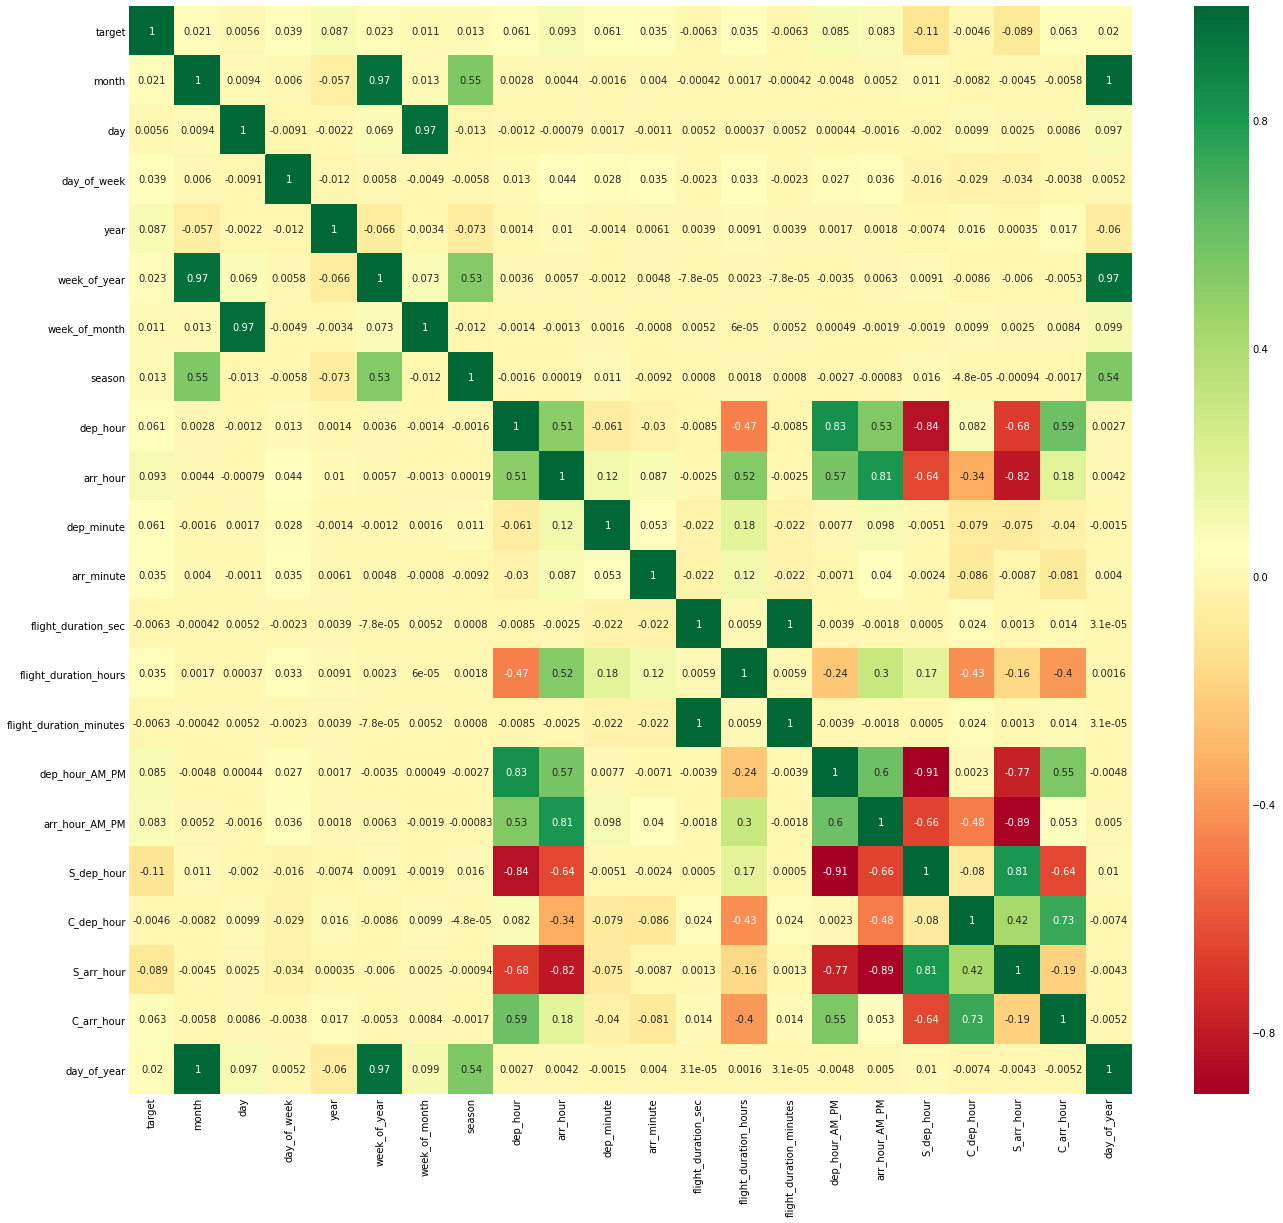

In [37]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [54]:
df.shape

(107833, 27)

In [189]:
# df = pd.read_csv('/home/souhagaa/Bureau/hackathon/tunisair/Train_clean.csv')

In [55]:
# we shuffle data
# df = df.sample(frac=1).reset_index(drop=True)

In [47]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target trajectory  month  day  \
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0    CMN-TUN      1    3   
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0    MXP-TUN      1   13   
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0    TUN-IST      1   16   
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0    DJE-NTE      1   17   
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0    TUN-ALG      1   17   

   day_of_week  year  week_of_year  week_of_month  season  dep_hour  arr_hour  \
0            6  2016            53              0       0        10        12   
1            2  2016             2              1       0        15        16   
2            5  2016             2              2       0         4         6   
3            6  2016             2              2       0        14        17   
4            6  2016             2              2       0        14        15   

   dep_minute  arr_minute  flight_duration_sec  flight_duration_hours  \
0          30          55                 8700                      2   
1           5          55                 6600                      1   
2          10          45                 9300                      2   
3          10           0                10200                      3   
4          30          50                 4800                      1   

   flight_duration_minutes  dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour  \
0                      145               0               1    0.500000   
1                      110               1               1   -0.707107   
2                      155               0               0    0.866025   
3                      170               1               1   -0.500000   
4                       80               1               1   -0.500000   

   C_dep_hour    S_arr_hour    C_arr_hour  day_of_year  
0   -0.866025  1.224647e-16 -1.000000e+00          3.0  
1   -0.707107 -8.660254e-01 -5.000000e-01         13.0  
2    0.500000  1.000000e+00  6.123234e-17         16.0  
3   -0.866025 -9.659258e-01 -2.588190e-01         17.0  
4   -0.866025 -7.071068e-01 -7.071068e-01         17.0

In [232]:
# !!!! only in case df is read from the file we need to convert the types back to datetime objects
# df['STD'] =  pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')
# df['STA'] =  pd.to_datetime(df['STA'], format='%Y-%m-%d %H:%M:%S')
# df['DATOP'] =  pd.to_datetime(df['DATOP'], format='%Y-%m-%d')

In [57]:
df.to_csv('/home/souhagaa/Bureau/hackathon/tunisair/Train_clean.csv', index=False)

In [48]:
df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'trajectory', 'month', 'day', 'day_of_week', 'year',
       'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
       'dep_minute', 'arr_minute', 'flight_duration_sec',
       'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
       'arr_hour_AM_PM', 'S_dep_hour', 'C_dep_hour', 'S_arr_hour',
       'C_arr_hour', 'day_of_year'],
      dtype='object')

In [51]:
# 'DEPSTN','ARRSTN','STATUS', 'AC','Flight', 'Year', 'Month', 'Day', 'Minute_of_came',
#         'DayofYear','Hour_of_go', 'Hour_of_came','Flight_Duration_minute','Flight_Duration_hour','Minute_of_go', 'DATOP' ,'Day_of_week','FLTID','Week_of_year','S_hour_go',
#        'C_hour_go', 'S_hour_came', 'C_hour_came'
# X = df[['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
#        'AC', 'trajectory', 'month', 'day', 'day_of_week', 'year',
#        'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
#        'dep_minute', 'arr_minute', 'flight_duration_sec',
#        'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
#        'arr_hour_AM_PM','S_dep_hour', 'C_dep_hour', 'S_arr_hour',
#        'C_arr_hour']]
# test = df_test[['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
#        'AC', 'trajectory', 'month', 'day', 'day_of_week', 'year',
#        'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
#        'dep_minute', 'arr_minute', 'flight_duration_sec',
#        'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
#        'arr_hour_AM_PM','S_dep_hour', 'C_dep_hour', 'S_arr_hour',
#        'C_arr_hour']]
train_cols = ['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'trajectory', 'month', 'day', 'day_of_week', 'year',
       'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
       'dep_minute', 'arr_minute', 'flight_duration_sec',
       'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
       'arr_hour_AM_PM', 'S_dep_hour', 'C_dep_hour', 'S_arr_hour',
       'C_arr_hour', 'day_of_year']
X = df[train_cols]
test = df_test[train_cols]
y = df['target']

In [52]:
# y = df['target']
# del df['target']
# X = df

In [53]:
X.head()

DATOP    FLTID DEPSTN ARRSTN                 STD                 STA  \
0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00 2016-01-03 12:55:00   
1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00 2016-01-13 16:55:00   
2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00 2016-01-16 06:45:00   
3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00 2016-01-17 17:00:00   
4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00 2016-01-17 15:50:00   

  STATUS         AC trajectory  month  day  day_of_week  year  week_of_year  \
0    ATA  TU 32AIMN    CMN-TUN      1    3            6  2016            53   
1    ATA  TU 31BIMO    MXP-TUN      1   13            2  2016             2   
2    ATA  TU 32AIMN    TUN-IST      1   16            5  2016             2   
3    ATA  TU 736IOK    DJE-NTE      1   17            6  2016             2   
4    ATA  TU 320IMU    TUN-ALG      1   17            6  2016             2   

   week_of_month  season  dep_hour  arr_hour  dep_minute  arr_minute  \
0              0       0        10        12          30          55   
1              1       0        15        16           5          55   
2              2       0         4         6          10          45   
3              2       0        14        17          10           0   
4              2       0        14        15          30          50   

   flight_duration_sec  flight_duration_hours  flight_duration_minutes  \
0                 8700                      2                      145   
1                 6600                      1                      110   
2                 9300                      2                      155   
3                10200                      3                      170   
4                 4800                      1                       80   

   dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour  C_dep_hour    S_arr_hour  \
0               0               1    0.500000   -0.866025  1.224647e-16   
1               1               1   -0.707107   -0.707107 -8.660254e-01   
2               0               0    0.866025    0.500000  1.000000e+00   
3               1               1   -0.500000   -0.866025 -9.659258e-01   
4               1               1   -0.500000   -0.866025 -7.071068e-01   

     C_arr_hour  day_of_year  
0 -1.000000e+00          3.0  
1 -5.000000e-01         13.0  
2  6.123234e-17         16.0  
3 -2.588190e-01         17.0  
4 -7.071068e-01         17.0

In [239]:
# del X['year']
# del X['ac_frequency']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=17)

In [69]:
categ_feat_idx = np.where(X_train.dtypes == 'object')[0]
categ_feat_idx

array([1, 2, 3, 6, 7, 8])

In [77]:
# from catboost import CatBoostRegressor
# model = CatBoostRegressor(iterations=700, depth= 10, l2_leaf_reg= 7, learning_rate= 0.1) 
# #depth= 10, l2_leaf_reg= 7, learning_rate= 0.1
# model.fit(X_train,y_train,verbose=False,cat_features=categ_feat_idx)

# from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=699, depth=10, learning_rate=0.1,l2_leaf_reg= 7, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categ_feat_idx,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 124.5906980	test: 123.2337665	best: 123.2337665 (0)	total: 320ms	remaining: 3m 43s
1:	learn: 122.5620731	test: 121.2149221	best: 121.2149221 (1)	total: 536ms	remaining: 3m 6s
2:	learn: 120.7738215	test: 119.4933891	best: 119.4933891 (2)	total: 853ms	remaining: 3m 17s
3:	learn: 119.2644233	test: 118.0697435	best: 118.0697435 (3)	total: 1.19s	remaining: 3m 26s
4:	learn: 118.0219154	test: 116.8394795	best: 116.8394795 (4)	total: 1.43s	remaining: 3m 18s
5:	learn: 116.8909587	test: 115.7118927	best: 115.7118927 (5)	total: 1.73s	remaining: 3m 20s
6:	learn: 115.9931427	test: 114.8620603	best: 114.8620603 (6)	total: 1.95s	remaining: 3m 12s
7:	learn: 115.3154893	test: 114.2168067	best: 114.2168067 (7)	total: 2.23s	remaining: 3m 12s
8:	learn: 114.6994213	test: 113.6168826	best: 113.6168826 (8)	total: 2.47s	remaining: 3m 9s
9:	learn: 114.2099517	test: 113.1966428	best: 113.1966428 (9)	total: 2.71s	remaining: 3m 6s
10:	learn: 113.7530721	test: 112.7539018	best: 112.7539018 (10)	total: 2.

87:	learn: 105.9234740	test: 108.3343507	best: 108.3267164 (86)	total: 23.4s	remaining: 2m 42s
88:	learn: 105.8576219	test: 108.3145631	best: 108.3145631 (88)	total: 23.7s	remaining: 2m 42s
89:	learn: 105.8353118	test: 108.3111097	best: 108.3111097 (89)	total: 23.9s	remaining: 2m 41s
90:	learn: 105.8304357	test: 108.3054795	best: 108.3054795 (90)	total: 23.9s	remaining: 2m 40s
91:	learn: 105.8074844	test: 108.3045801	best: 108.3045801 (91)	total: 24.2s	remaining: 2m 39s
92:	learn: 105.7574170	test: 108.2749298	best: 108.2749298 (92)	total: 24.5s	remaining: 2m 39s
93:	learn: 105.6877604	test: 108.2717098	best: 108.2717098 (93)	total: 24.8s	remaining: 2m 39s
94:	learn: 105.6439770	test: 108.2583808	best: 108.2583808 (94)	total: 25.4s	remaining: 2m 41s
95:	learn: 105.5958882	test: 108.2611584	best: 108.2583808 (94)	total: 25.7s	remaining: 2m 41s
96:	learn: 105.5805380	test: 108.2567149	best: 108.2567149 (96)	total: 25.9s	remaining: 2m 40s
97:	learn: 105.5458373	test: 108.2344408	best: 108

172:	learn: 102.6580855	test: 107.5612673	best: 107.5612673 (172)	total: 45.6s	remaining: 2m 18s
173:	learn: 102.6324948	test: 107.5571990	best: 107.5571990 (173)	total: 45.9s	remaining: 2m 18s
174:	learn: 102.5922582	test: 107.5633067	best: 107.5571990 (173)	total: 46.2s	remaining: 2m 18s
175:	learn: 102.5510221	test: 107.5672527	best: 107.5571990 (173)	total: 46.4s	remaining: 2m 17s
176:	learn: 102.4893605	test: 107.5638221	best: 107.5571990 (173)	total: 46.7s	remaining: 2m 17s
177:	learn: 102.3957288	test: 107.5506656	best: 107.5506656 (177)	total: 46.9s	remaining: 2m 17s
178:	learn: 102.3880648	test: 107.5520140	best: 107.5506656 (177)	total: 47.2s	remaining: 2m 17s
179:	learn: 102.3546997	test: 107.5380249	best: 107.5380249 (179)	total: 47.4s	remaining: 2m 16s
180:	learn: 102.3222956	test: 107.5387472	best: 107.5380249 (179)	total: 47.7s	remaining: 2m 16s
181:	learn: 102.3035083	test: 107.5403404	best: 107.5380249 (179)	total: 48s	remaining: 2m 16s
182:	learn: 102.2680131	test: 10

258:	learn: 99.7142176	test: 107.0548240	best: 107.0537326 (254)	total: 1m 10s	remaining: 1m 59s
259:	learn: 99.6913260	test: 107.0479646	best: 107.0479646 (259)	total: 1m 10s	remaining: 1m 59s
260:	learn: 99.6811411	test: 107.0470540	best: 107.0470540 (260)	total: 1m 11s	remaining: 1m 59s
261:	learn: 99.6309418	test: 107.0510242	best: 107.0470540 (260)	total: 1m 11s	remaining: 1m 59s
262:	learn: 99.6288414	test: 107.0479381	best: 107.0470540 (260)	total: 1m 11s	remaining: 1m 58s
263:	learn: 99.6208546	test: 107.0424073	best: 107.0424073 (263)	total: 1m 11s	remaining: 1m 58s
264:	learn: 99.5601255	test: 107.0092044	best: 107.0092044 (264)	total: 1m 12s	remaining: 1m 58s
265:	learn: 99.5231939	test: 107.0116381	best: 107.0092044 (264)	total: 1m 12s	remaining: 1m 58s
266:	learn: 99.5134846	test: 107.0116032	best: 107.0092044 (264)	total: 1m 12s	remaining: 1m 57s
267:	learn: 99.4824330	test: 107.0025995	best: 107.0025995 (267)	total: 1m 13s	remaining: 1m 57s
268:	learn: 99.4376343	test: 1

343:	learn: 97.2029749	test: 106.6748816	best: 106.6682683 (339)	total: 1m 35s	remaining: 1m 38s
344:	learn: 97.1931528	test: 106.6737745	best: 106.6682683 (339)	total: 1m 35s	remaining: 1m 38s
345:	learn: 97.1741705	test: 106.6662750	best: 106.6662750 (345)	total: 1m 35s	remaining: 1m 37s
346:	learn: 97.1605446	test: 106.6571410	best: 106.6571410 (346)	total: 1m 36s	remaining: 1m 37s
347:	learn: 97.1478279	test: 106.6573423	best: 106.6571410 (346)	total: 1m 36s	remaining: 1m 37s
348:	learn: 97.1400875	test: 106.6585785	best: 106.6571410 (346)	total: 1m 36s	remaining: 1m 37s
349:	learn: 97.1218623	test: 106.6564413	best: 106.6564413 (349)	total: 1m 37s	remaining: 1m 36s
350:	learn: 97.0939906	test: 106.6446361	best: 106.6446361 (350)	total: 1m 37s	remaining: 1m 36s
351:	learn: 97.0715225	test: 106.6297382	best: 106.6297382 (351)	total: 1m 37s	remaining: 1m 36s
352:	learn: 97.0628509	test: 106.6294738	best: 106.6294738 (352)	total: 1m 37s	remaining: 1m 36s
353:	learn: 97.0188607	test: 1

428:	learn: 95.1734971	test: 106.3722497	best: 106.3722497 (428)	total: 2m 2s	remaining: 1m 16s
429:	learn: 95.1552190	test: 106.3799085	best: 106.3722497 (428)	total: 2m 2s	remaining: 1m 16s
430:	learn: 95.1152544	test: 106.3842701	best: 106.3722497 (428)	total: 2m 2s	remaining: 1m 16s
431:	learn: 95.0971699	test: 106.3827698	best: 106.3722497 (428)	total: 2m 3s	remaining: 1m 16s
432:	learn: 95.0786931	test: 106.3844539	best: 106.3722497 (428)	total: 2m 3s	remaining: 1m 15s
433:	learn: 95.0417291	test: 106.3835916	best: 106.3722497 (428)	total: 2m 3s	remaining: 1m 15s
434:	learn: 95.0182785	test: 106.3816492	best: 106.3722497 (428)	total: 2m 4s	remaining: 1m 15s
435:	learn: 95.0074083	test: 106.3726223	best: 106.3722497 (428)	total: 2m 4s	remaining: 1m 15s
436:	learn: 94.9865141	test: 106.3753275	best: 106.3722497 (428)	total: 2m 4s	remaining: 1m 14s
437:	learn: 94.9522128	test: 106.3775668	best: 106.3722497 (428)	total: 2m 5s	remaining: 1m 14s
438:	learn: 94.9197317	test: 106.3780619

514:	learn: 92.9709684	test: 106.0685158	best: 106.0649255 (510)	total: 2m 29s	remaining: 53.3s
515:	learn: 92.9447370	test: 106.0556275	best: 106.0556275 (515)	total: 2m 29s	remaining: 53s
516:	learn: 92.9293129	test: 106.0572928	best: 106.0556275 (515)	total: 2m 29s	remaining: 52.8s
517:	learn: 92.9198440	test: 106.0579720	best: 106.0556275 (515)	total: 2m 30s	remaining: 52.5s
518:	learn: 92.9048523	test: 106.0537974	best: 106.0537974 (518)	total: 2m 30s	remaining: 52.2s
519:	learn: 92.8841406	test: 106.0525980	best: 106.0525980 (519)	total: 2m 31s	remaining: 52s
520:	learn: 92.8603975	test: 106.0487651	best: 106.0487651 (520)	total: 2m 31s	remaining: 51.7s
521:	learn: 92.8339434	test: 106.0486391	best: 106.0486391 (521)	total: 2m 31s	remaining: 51.3s
522:	learn: 92.8278840	test: 106.0519525	best: 106.0486391 (521)	total: 2m 31s	remaining: 51s
523:	learn: 92.7850885	test: 106.0536275	best: 106.0486391 (521)	total: 2m 31s	remaining: 50.7s
524:	learn: 92.7771238	test: 106.0542307	best:

600:	learn: 90.8296544	test: 105.8615175	best: 105.8615175 (600)	total: 3m 2s	remaining: 29.8s
601:	learn: 90.7978833	test: 105.8628778	best: 105.8615175 (600)	total: 3m 3s	remaining: 29.5s
602:	learn: 90.7835559	test: 105.8682297	best: 105.8615175 (600)	total: 3m 3s	remaining: 29.2s
603:	learn: 90.7747768	test: 105.8672925	best: 105.8615175 (600)	total: 3m 4s	remaining: 29s
604:	learn: 90.7377683	test: 105.8662122	best: 105.8615175 (600)	total: 3m 4s	remaining: 28.7s
605:	learn: 90.7260240	test: 105.8537771	best: 105.8537771 (605)	total: 3m 5s	remaining: 28.4s
606:	learn: 90.7217415	test: 105.8536780	best: 105.8536780 (606)	total: 3m 5s	remaining: 28.2s
607:	learn: 90.7123873	test: 105.8502819	best: 105.8502819 (607)	total: 3m 6s	remaining: 27.9s
608:	learn: 90.6817897	test: 105.8455478	best: 105.8455478 (608)	total: 3m 7s	remaining: 27.6s
609:	learn: 90.6611077	test: 105.8386822	best: 105.8386822 (609)	total: 3m 7s	remaining: 27.3s
610:	learn: 90.6251397	test: 105.8401886	best: 105.8

686:	learn: 88.8805346	test: 105.6414868	best: 105.6370397 (683)	total: 3m 33s	remaining: 3.73s
687:	learn: 88.8252904	test: 105.6461877	best: 105.6370397 (683)	total: 3m 34s	remaining: 3.42s
688:	learn: 88.7889177	test: 105.6418386	best: 105.6370397 (683)	total: 3m 34s	remaining: 3.11s
689:	learn: 88.7788784	test: 105.6395436	best: 105.6370397 (683)	total: 3m 34s	remaining: 2.8s
690:	learn: 88.7642304	test: 105.6300286	best: 105.6300286 (690)	total: 3m 34s	remaining: 2.49s
691:	learn: 88.7341747	test: 105.6276502	best: 105.6276502 (691)	total: 3m 35s	remaining: 2.18s
692:	learn: 88.7231392	test: 105.6252489	best: 105.6252489 (692)	total: 3m 35s	remaining: 1.86s
693:	learn: 88.6929795	test: 105.6201558	best: 105.6201558 (693)	total: 3m 35s	remaining: 1.55s
694:	learn: 88.6881858	test: 105.6175103	best: 105.6175103 (694)	total: 3m 36s	remaining: 1.24s
695:	learn: 88.6801405	test: 105.6190296	best: 105.6175103 (694)	total: 3m 36s	remaining: 933ms
696:	learn: 88.6613720	test: 105.6253525	

In [78]:
predictions = model.predict(X_test)
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(y_test,predictions))
print(rmse)
#106.61722528055746


105.61751026133135


In [ ]:
model = CatBoostRegressor()
parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [650, 700, 750]
             }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train,cat_features=categ_feat_idx,eval_set=(X_test, y_test))    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      grid.best_estimator_)

print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)

In [72]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

importance
feature                            
FLTID                        12.548
AC                           10.339
day_of_year                   9.026
day                           6.228
trajectory                    6.227
DEPSTN                        5.620
day_of_week                   4.684
ARRSTN                        4.667
DATOP                         4.288
STD                           3.922
week_of_year                  3.319
STA                           3.053
flight_duration_sec           2.872
arr_minute                    2.691
STATUS                        2.616
dep_minute                    2.386
S_arr_hour                    1.825
arr_hour                      1.807
S_dep_hour                    1.687
C_arr_hour                    1.652
C_dep_hour                    1.622
dep_hour                      1.421
year                          1.234
flight_duration_minutes       0.940
flight_duration_hours         0.723
week_of_month                 0.658
dep_hour_AM_PM                0.651
season                        0.590
month                         0.424
arr_hour_AM_PM                0.282

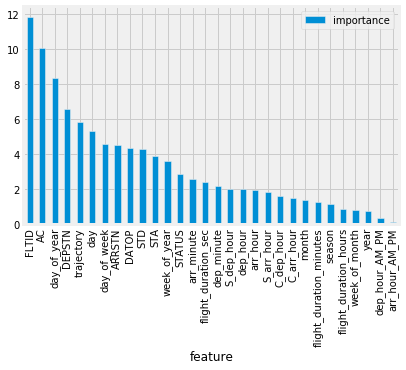

In [62]:
importances.plot.bar()


In [80]:
# I again fit the model but with the whole dataset to get more data into training
# model.fit(X, y,cat_features=categ_feat_idx,eval_set=(X_test, y_test))

0:	learn: 124.4087879	test: 123.1550860	best: 123.1550860 (0)	total: 326ms	remaining: 3m 47s
1:	learn: 122.2934166	test: 121.0616799	best: 121.0616799 (1)	total: 561ms	remaining: 3m 15s
2:	learn: 120.5118186	test: 119.2392501	best: 119.2392501 (2)	total: 822ms	remaining: 3m 10s
3:	learn: 118.9886437	test: 117.7374484	best: 117.7374484 (3)	total: 1.06s	remaining: 3m 4s
4:	learn: 117.7636681	test: 116.5192701	best: 116.5192701 (4)	total: 1.31s	remaining: 3m 1s
5:	learn: 116.6735829	test: 115.4679880	best: 115.4679880 (5)	total: 1.57s	remaining: 3m 1s
6:	learn: 115.8325432	test: 114.6423771	best: 114.6423771 (6)	total: 1.8s	remaining: 2m 57s
7:	learn: 115.0692605	test: 113.8754079	best: 113.8754079 (7)	total: 2.03s	remaining: 2m 55s
8:	learn: 114.4970470	test: 113.2220242	best: 113.2220242 (8)	total: 2.31s	remaining: 2m 57s
9:	learn: 114.0196669	test: 112.7538129	best: 112.7538129 (9)	total: 2.57s	remaining: 2m 56s
10:	learn: 113.5547004	test: 112.2896075	best: 112.2896075 (10)	total: 2.7

87:	learn: 106.4377426	test: 106.1423479	best: 106.1423479 (87)	total: 24s	remaining: 2m 46s
88:	learn: 106.4077237	test: 106.1137784	best: 106.1137784 (88)	total: 24.4s	remaining: 2m 46s
89:	learn: 106.3705504	test: 106.0710677	best: 106.0710677 (89)	total: 24.7s	remaining: 2m 47s
90:	learn: 106.3413287	test: 106.0562066	best: 106.0562066 (90)	total: 25.1s	remaining: 2m 47s
91:	learn: 106.3156226	test: 106.0175647	best: 106.0175647 (91)	total: 25.7s	remaining: 2m 49s
92:	learn: 106.2775149	test: 105.9918772	best: 105.9918772 (92)	total: 26.2s	remaining: 2m 50s
93:	learn: 106.1945922	test: 105.9539168	best: 105.9539168 (93)	total: 26.6s	remaining: 2m 51s
94:	learn: 106.1529178	test: 105.9098937	best: 105.9098937 (94)	total: 26.9s	remaining: 2m 51s
95:	learn: 106.0859464	test: 105.8821662	best: 105.8821662 (95)	total: 27.3s	remaining: 2m 51s
96:	learn: 106.0528182	test: 105.8496573	best: 105.8496573 (96)	total: 27.7s	remaining: 2m 51s
97:	learn: 106.0193230	test: 105.8184508	best: 105.8

172:	learn: 102.9999118	test: 103.8122490	best: 103.8122490 (172)	total: 49.2s	remaining: 2m 29s
173:	learn: 102.9804560	test: 103.8011935	best: 103.8011935 (173)	total: 49.5s	remaining: 2m 29s
174:	learn: 102.9678988	test: 103.7967630	best: 103.7967630 (174)	total: 49.8s	remaining: 2m 29s
175:	learn: 102.9513223	test: 103.7833474	best: 103.7833474 (175)	total: 50.1s	remaining: 2m 28s
176:	learn: 102.9370576	test: 103.7568275	best: 103.7568275 (176)	total: 50.5s	remaining: 2m 28s
177:	learn: 102.8959168	test: 103.7410380	best: 103.7410380 (177)	total: 50.7s	remaining: 2m 28s
178:	learn: 102.8924393	test: 103.7406543	best: 103.7406543 (178)	total: 50.9s	remaining: 2m 28s
179:	learn: 102.8863632	test: 103.7396416	best: 103.7396416 (179)	total: 51.2s	remaining: 2m 27s
180:	learn: 102.8372630	test: 103.6906791	best: 103.6906791 (180)	total: 51.7s	remaining: 2m 27s
181:	learn: 102.7969272	test: 103.6563599	best: 103.6563599 (181)	total: 52s	remaining: 2m 27s
182:	learn: 102.7378314	test: 10

257:	learn: 100.5522874	test: 102.2281040	best: 102.2234525 (256)	total: 1m 15s	remaining: 2m 9s
258:	learn: 100.5236568	test: 102.2046465	best: 102.2046465 (258)	total: 1m 15s	remaining: 2m 8s
259:	learn: 100.4630409	test: 102.1714528	best: 102.1714528 (259)	total: 1m 16s	remaining: 2m 8s
260:	learn: 100.4356862	test: 102.1568403	best: 102.1568403 (260)	total: 1m 16s	remaining: 2m 8s
261:	learn: 100.4026209	test: 102.1365169	best: 102.1365169 (261)	total: 1m 16s	remaining: 2m 8s
262:	learn: 100.3916913	test: 102.1279369	best: 102.1279369 (262)	total: 1m 17s	remaining: 2m 7s
263:	learn: 100.3716860	test: 102.0707117	best: 102.0707117 (263)	total: 1m 17s	remaining: 2m 7s
264:	learn: 100.3620552	test: 102.0635576	best: 102.0635576 (264)	total: 1m 18s	remaining: 2m 7s
265:	learn: 100.3512968	test: 102.0609161	best: 102.0609161 (265)	total: 1m 18s	remaining: 2m 8s
266:	learn: 100.3442491	test: 102.0508609	best: 102.0508609 (266)	total: 1m 19s	remaining: 2m 7s
267:	learn: 100.3198507	test: 

342:	learn: 98.3132607	test: 100.8546967	best: 100.8546967 (342)	total: 1m 41s	remaining: 1m 45s
343:	learn: 98.2809007	test: 100.8340396	best: 100.8340396 (343)	total: 1m 41s	remaining: 1m 44s
344:	learn: 98.2742719	test: 100.8316683	best: 100.8316683 (344)	total: 1m 41s	remaining: 1m 44s
345:	learn: 98.2047437	test: 100.7914319	best: 100.7914319 (345)	total: 1m 42s	remaining: 1m 44s
346:	learn: 98.1974698	test: 100.7869072	best: 100.7869072 (346)	total: 1m 42s	remaining: 1m 44s
347:	learn: 98.1895575	test: 100.7854603	best: 100.7854603 (347)	total: 1m 43s	remaining: 1m 44s
348:	learn: 98.1752714	test: 100.7843074	best: 100.7843074 (348)	total: 1m 43s	remaining: 1m 43s
349:	learn: 98.1649784	test: 100.7743546	best: 100.7743546 (349)	total: 1m 44s	remaining: 1m 43s
350:	learn: 98.1594673	test: 100.7692436	best: 100.7692436 (350)	total: 1m 44s	remaining: 1m 43s
351:	learn: 98.1311857	test: 100.7571393	best: 100.7571393 (351)	total: 1m 44s	remaining: 1m 43s
352:	learn: 98.1104929	test: 1

428:	learn: 96.2283254	test: 99.5205778	best: 99.5205778 (428)	total: 2m 10s	remaining: 1m 21s
429:	learn: 96.1892272	test: 99.4783945	best: 99.4783945 (429)	total: 2m 10s	remaining: 1m 21s
430:	learn: 96.1686621	test: 99.4727023	best: 99.4727023 (430)	total: 2m 10s	remaining: 1m 21s
431:	learn: 96.1493907	test: 99.4438599	best: 99.4438599 (431)	total: 2m 11s	remaining: 1m 20s
432:	learn: 96.1244627	test: 99.4392768	best: 99.4392768 (432)	total: 2m 11s	remaining: 1m 20s
433:	learn: 96.0867559	test: 99.4254352	best: 99.4254352 (433)	total: 2m 11s	remaining: 1m 20s
434:	learn: 96.0736286	test: 99.4245171	best: 99.4245171 (434)	total: 2m 11s	remaining: 1m 19s
435:	learn: 96.0308905	test: 99.3787183	best: 99.3787183 (435)	total: 2m 12s	remaining: 1m 19s
436:	learn: 96.0119302	test: 99.3673656	best: 99.3673656 (436)	total: 2m 12s	remaining: 1m 19s
437:	learn: 96.0008610	test: 99.3652213	best: 99.3652213 (437)	total: 2m 12s	remaining: 1m 18s
438:	learn: 95.9910995	test: 99.3396136	best: 99.3

515:	learn: 94.2509207	test: 98.4969203	best: 98.4969203 (515)	total: 2m 34s	remaining: 54.9s
516:	learn: 94.2060796	test: 98.4757791	best: 98.4757791 (516)	total: 2m 35s	remaining: 54.6s
517:	learn: 94.1864767	test: 98.4770603	best: 98.4757791 (516)	total: 2m 35s	remaining: 54.3s
518:	learn: 94.1774868	test: 98.4745947	best: 98.4745947 (518)	total: 2m 35s	remaining: 54s
519:	learn: 94.1671429	test: 98.4750491	best: 98.4745947 (518)	total: 2m 36s	remaining: 53.8s
520:	learn: 94.1212459	test: 98.4553679	best: 98.4553679 (520)	total: 2m 36s	remaining: 53.6s
521:	learn: 94.0984316	test: 98.4442519	best: 98.4442519 (521)	total: 2m 37s	remaining: 53.4s
522:	learn: 94.0541552	test: 98.3869327	best: 98.3869327 (522)	total: 2m 37s	remaining: 53.1s
523:	learn: 94.0443316	test: 98.3866016	best: 98.3866016 (523)	total: 2m 38s	remaining: 52.8s
524:	learn: 94.0118784	test: 98.3573943	best: 98.3573943 (524)	total: 2m 38s	remaining: 52.6s
525:	learn: 93.9903220	test: 98.3460331	best: 98.3460331 (525)

603:	learn: 92.4449601	test: 97.4381340	best: 97.4381340 (603)	total: 3m 1s	remaining: 28.5s
604:	learn: 92.4258148	test: 97.4322143	best: 97.4322143 (604)	total: 3m 1s	remaining: 28.2s
605:	learn: 92.4175066	test: 97.4338128	best: 97.4322143 (604)	total: 3m 1s	remaining: 27.9s
606:	learn: 92.4124151	test: 97.4289332	best: 97.4289332 (606)	total: 3m 2s	remaining: 27.6s
607:	learn: 92.4030770	test: 97.4260288	best: 97.4260288 (607)	total: 3m 2s	remaining: 27.3s
608:	learn: 92.3960220	test: 97.4268196	best: 97.4260288 (607)	total: 3m 2s	remaining: 27s
609:	learn: 92.3711460	test: 97.4024825	best: 97.4024825 (609)	total: 3m 2s	remaining: 26.7s
610:	learn: 92.3557140	test: 97.3943172	best: 97.3943172 (610)	total: 3m 3s	remaining: 26.4s
611:	learn: 92.3453089	test: 97.3893514	best: 97.3893514 (611)	total: 3m 3s	remaining: 26.1s
612:	learn: 92.2927207	test: 97.3433124	best: 97.3433124 (612)	total: 3m 3s	remaining: 25.8s
613:	learn: 92.2533703	test: 97.3045531	best: 97.3045531 (613)	total: 3m

691:	learn: 90.7381240	test: 96.4153609	best: 96.4153609 (691)	total: 3m 28s	remaining: 2.11s
692:	learn: 90.7195358	test: 96.4131495	best: 96.4131495 (692)	total: 3m 28s	remaining: 1.81s
693:	learn: 90.6953970	test: 96.3886135	best: 96.3886135 (693)	total: 3m 29s	remaining: 1.51s
694:	learn: 90.6579038	test: 96.3560155	best: 96.3560155 (694)	total: 3m 29s	remaining: 1.21s
695:	learn: 90.6499432	test: 96.3566513	best: 96.3560155 (694)	total: 3m 29s	remaining: 905ms
696:	learn: 90.6373459	test: 96.3542725	best: 96.3542725 (696)	total: 3m 30s	remaining: 603ms
697:	learn: 90.6237641	test: 96.3429183	best: 96.3429183 (697)	total: 3m 30s	remaining: 301ms
698:	learn: 90.6204726	test: 96.3390902	best: 96.3390902 (698)	total: 3m 30s	remaining: 0us

bestTest = 96.33909017
bestIteration = 698



In [81]:
y_pred = model.predict(test)

In [82]:
any(y_pred<0)

True

In [83]:
y_pred[y_pred < 0] =0

In [84]:
submission= pd.DataFrame({'ID':df_test["ID"],'target':y_pred})
submission.to_csv("submission.csv",index=False)

<h3> Linear Regression </h3>

In [180]:
# one_hot = pd.get_dummies(df['STATUS'])
# df = df.drop('STATUS',axis = 1)
# df = df.join(one_hot)

In [181]:
# one_hot = pd.get_dummies(df['DEPSTN'],prefix='depart_')
# df = df.drop('DEPSTN',axis = 1)
# df = df.join(one_hot)

In [182]:
# one_hot = pd.get_dummies(df['ARRSTN'], prefix='arrival_')
# df = df.drop('ARRSTN',axis = 1)
# df = df.join(one_hot)

In [183]:
# one_hot = pd.get_dummies(df['AC'], prefix='ac_')
# df = df.drop('AC',axis = 1)
# df = df.join(one_hot)

In [229]:
# le = LabelEncoder()
# enc = OneHotEncoder(sparse=False)
# df['DEPSTN'] = le.fit_transform(df['DEPSTN'])
# df['ARRSTN'] = le.fit_transform(df['ARRSTN'])
# df['STATUS'] = le.fit_transform(df['STATUS'])
# df['AC'] = le.fit_transform(df['AC'])

In [233]:
# df['DATOP_ts'] = df.DATOP.values.astype(np.int64) // 10 ** 9
# df['STD_ts'] = df.STD.values.astype(np.int64) // 10 ** 9
# df['STA_ts'] = df.STA.values.astype(np.int64) // 10 ** 9
# del df['DATOP']
# del df['STA']
# del df['STD']

In [59]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'train_id_11434'

In [242]:
results = model.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results)
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)
# MSE:  5954526.582315134   R2 Score:  -461.04557347688393
# when deleting year and ac_frequency MSE:  13643.94079805509   R2 Score:  0.058992522154372895
# WITH label encoding MSE:  12795.027061727462   R2 Score:  0.036762754570380474
# MSE:  12059.485969460224   R2 Score:  0.0421820337368739 labelenc with delet of year and ac_freq

MSE:  12059.485969460224   R2 Score:  0.0421820337368739


In [245]:
#memory error
for i in range(5,10):
    poly = PolynomialFeatures(degree = i)
    regr = linear_model.LinearRegression()
    X_ = poly.fit_transform(X_train)
    regr.fit(X_, y_train)
    X_ = poly.fit_transform(X_test)
    results = regr.predict(X_)
    score1 = metrics.mean_squared_error(y_test,results )
    score2 = metrics.r2_score(y_test,results )
    print('Model with Polynominal Degree', i, 'MSE: ',score1, '  R2 Score: ', score2)
# 5 : Model with Polynominal Degree 5 MSE:  11915.27537981318   R2 Score:  0.053635879617132454


Model with Polynominal Degree 1 MSE:  12059.485969460296   R2 Score:  0.04218203373686813
Model with Polynominal Degree 2 MSE:  12025.860911835494   R2 Score:  0.044852685238203294
Model with Polynominal Degree 3 MSE:  12667.95185097613   R2 Score:  -0.006145030505330329
Model with Polynominal Degree 4 MSE:  12009.528564292783   R2 Score:  0.046149872858577634
Model with Polynominal Degree 5 MSE:  11915.27537981318   R2 Score:  0.053635879617132454


MemoryError: 